# ** DIscBIO: a user-friendly pipeline for biomarker discovery in single-cell transcriptomics**

The pipeline consists of four successive steps: data pre-processing, cellular clustering and pseudo-temporal ordering, determining differential expressed genes and identifying biomarkers.

![DIsccBIO](DiscBIO.png)

## Required Packages

In [1]:
library(DIscBIO)
library(enrichR)


Warning message:
"package 'enrichR' was built under R version 3.6.2"Welcome to enrichR
Checking connection ... Connection is Live!


## Loading dataset

The dataset should be formatted in a data frame where columns refer to samples and rows refer to genes. 

In [2]:
FileName<-"valuesG1ms"

#load(paste0(FileName,".rda"))
#DataSet<-get(FileName)

DataSet <- read.csv(file = paste0(FileName,".csv"), sep = ";",header=T)
rownames(DataSet)<-DataSet[,1]
DataSet<-DataSet[,-1]

head(DataSet)
cat(paste0("The ", FileName," dataset contains:","\n","Genes: ",length(DataSet[,1]),"\n","cells: ",length(DataSet[1,]),"\n"))



G1  G1_1 G1_2 G1_3 G1_4 G1_5 G1_6 G1_7 G1_8 G1_9 ... G2_22
ENSG00000000003 360 157  495  437  136  328  253  1101 39   253  ... 725  
ENSG00000000005   0   0    0    0    0    0    0     0  0     0  ...   0  
ENSG00000000419 111 174  269   70  179   93   57    60 35    91  ... 104  
ENSG00000000457   2   5    0    0    0    1    1     3  0     1  ...   1  
ENSG00000000460 179   0  212    0    0  135   47     0  0   159  ...  77  
ENSG00000000938   0   0    0    0    0    0    0     0  0     0  ...   0  
                G2_23 G2_24 G2_25 G2_26 G2_27 G2_28 G2_29 G2_30 G2_31
ENSG00000000003 851   299   464   551   620   488   452   424   397  
ENSG00000000005   0     0     0     0     0     0     0     0     0  
ENSG00000000419  35   297   208    69   113   278   109    87   115  
ENSG00000000457   0     0     0     3     0     3     0     2     1  
ENSG00000000460   0     0     0   202   154   259    99   151    84  
ENSG00000000938   0     0     0     0     0     0     0     0     0

The valuesG1ms dataset contains:
Genes: 59838
cells: 94


## 1. Data Pre-processing

Prior to applying data analysis methods, it is standard to pre-process the raw read counts resulted from the sequencing. The preprocessing approach depends on the existence or absence of ERCC spike-ins. In both cases, it includes normalization of read counts and gene filtering. 

#### Normalization of read counts
To account for RNA composition and sequencing depth among samples (single-cells), the normalization method “median of ratios” is used. This method takes the ratio of the gene instantaneous median to the total counts for all genes in that cell (column median). The gene instantaneous median is the product of multiplying the median of the total counts across all cells (row median) with the read of the target gene in each cell. This normalization method makes it possible to compare the normalized counts for each gene equally between samples.

#### Gene filtering
The key idea in filtering genes is to appoint the genes that manifest abundant variation across samples. Filtering genes is a critical step due to its dramatic impact on the downstream analysis. In case the raw data includes ERCC spike-ins, genes will be filtered based on variability in comparison to a noise level estimated from the ERCC spike-ins according to an algorithm developed by Brennecke et al (Brennecke et al., 2013). This algorithm utilizes the dependence of technical noise on the average read count and fits a model to the ERCC spike-ins. Further gene filtering can be implemented based on gene expression.
In case the raw data does not include ERCC spike-ins, genes will be only filtered based on minimum expression in certain number of cells.


![DataPre-processing](Data-Preprocessing.png)

In [3]:
sc<- DISCBIO(DataSet)    

### 1.1. Filtering and normalizing the raw data that includes ERCCs

Filtering the raw data that includes ERCCs can be done by applying the “NoiseFiltering” function, which includes several parameters:
    - object: the outcome of running the DISCBIO() function.
    - percentile: A numeric value of the percentile. It is used to validate the ERCC spik-ins. Default is 0.8.
    - CV: A numeric value of the coefficient of variation. It is used to validate the ERCC spik-ins. Default is 0.5.
    - geneCol: Color of the genes that did not pass the filtration.
    - FgeneCol: Color of the genes that passt the filtration.
    - erccCol: Color of the ERCC spik-ins.
    - Val: A logical vector that allows plotting only the validated ERCC spike-ins. Default is TRUE. If Val=FALSE will 
      plot all the ERCC spike-ins.
    - plot: A logical vector that allows plotting the technical noise. Default is TRUE. 
    - export: A logical vector that allows writing the final gene list in excel file. Default is TRUE. 
    - quiet: if `TRUE`, suppresses printed output
    
To normalize the raw sequencing reads the function Normalizedata() should be used, this function takes 8 parameters. 
- In case the user would like just to normalize the reads without any further gene filtering the parameters minexpr and minnumber should be set to 0.
- In case the user would like just to normalize the reads and run gene filtering based on gene expression the parameters minexpr and minnumber should have values. This function will discard cells with less than mintotal transcripts. Genes that are not expressed at minexpr transcripts in at least minnumber cells are discarded.
          
The function Normalizedata() normalizes the count reads using the normalization method “median of ratios” 
          
To Finalize the preprocessing the function FinalPreprocessing() should be implemented by setting the parameter "GeneFlitering" to NoiseF ( whether the dditional gene filtering step based on gene expression was implemented on not).

Cut-off value for the ERCCs=  12.5 

Coefficients of the fit: 
        a0    a1tilde 
 0.0200366 70.4893629 
Explained variances of log CV^2 values=  0.84 

Number of genes that passed the filtering=  5684 

The filtered gene list was saved as: Noise_filtering_genes_test
The gene filtering method= Noise filtering

 The Filtered Normalized dataset contains:
 Genes: 5684 
 cells: 94 

The Filtered Normalized dataset was saved as: filteredDataset.Rdata


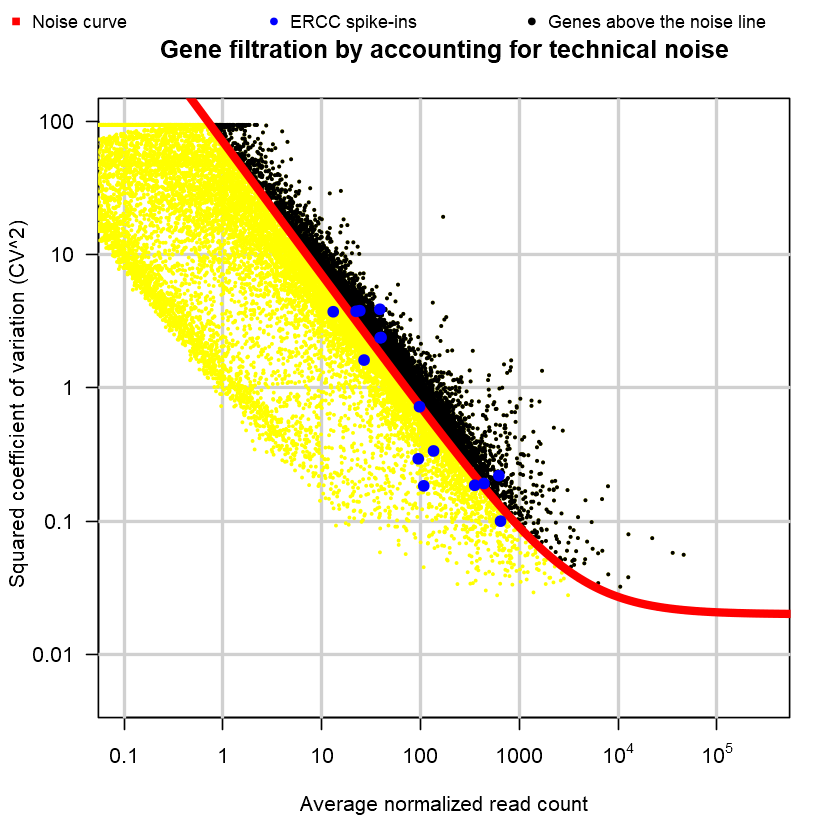

In [4]:
sc<-NoiseFiltering(sc,percentile=0.8, CV=0.3)       

####  Normalizing the reads without any further gene filtering
sc<-Normalizedata(sc, mintotal=1000, minexpr=0, minnumber=0, maxexpr=Inf, downsample=FALSE, dsn=1, rseed=17000) 

####  Additional gene filtering step based on gene expression
#MIínExp<- mean(rowMeans(DataSet,na.rm=TRUE))
#MIínExp
#MinNumber<- round(length(DataSet[1,])/3)    # To be expressed in at least one third of the cells.
#MinNumber
#sc<-Normalizedata(sc, mintotal=1000, minexpr=MIínExp, minnumber=MinNumber, maxexpr=Inf, downsample=FALSE, dsn=1, rseed=17000) 

sc<-FinalPreprocessing(sc,GeneFlitering="NoiseF",export = TRUE) ### The GeneFiltering can be either "NoiseF" or"ExpF"

### 1.2. Filtering and normalizing the raw data that does not include ERCCs

To normalize and filter the raw data that does not include ERCCs can be done by applying the function Normalizedata() and giving  the parameters minexpr and minnumber some values. This function will discard cells with less than mintotal transcripts. Genes that are not expressed at minexpr transcripts in at least minnumber cells are discarded. Furthermore, it will normalize the count reads using the normalization method “median of ratios”.
          
To Finalize the preprocessing the function FinalPreprocessing() should be implemented by setting the parameter "GeneFlitering" to ExpF.

###                                               ¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤ Running this cell will overwrite the previous cell ¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤

In [5]:
#OnlyExpressionFiltering=TRUE           
OnlyExpressionFiltering=FALSE         

if (OnlyExpressionFiltering==TRUE){
    MIínExp<- mean(rowMeans(DataSet,na.rm=TRUE))
    MIínExp
    MinNumber<- round(length(DataSet[1,])/3)    # To be expressed in at least one third of the cells.
    MinNumber
    sc<-Normalizedata(sc, mintotal=1000, minexpr=MIínExp, minnumber=MinNumber, maxexpr=Inf, downsample=FALSE, dsn=1, rseed=17000) #### In this case this function is used to filter out genes and cells.
    sc<-FinalPreprocessing(sc,GeneFlitering="ExpF",export = TRUE)  
}

## 2. Cellular Clustering and Pseudo Time ordering

Cellular clustering is performed according to the gene expression profiles to detect cellular sub-population with unique properties. After clustering, pseudo-temporal ordering is generated to indicate the cellular differentiation degree. 

![PSCAN](Clustering.png)

## 2.1. K-means Clustering

Rare cell type Identification algorithm (RaceID) was used to cluster the pre-processed data using k-means on a similarity distance matrix, which was based on Pearson correlation and the similarity matrix was computed as “1 – Pearson correlation”. The approach of the proposed clustering, i.e., applying k-means on a similarity distance matrix using the Euclidean metric, improves cluster separation. RaceID estimates the number of clusters by finding the minimal clusters' number at the saturation level of gap statistics, which standardizes the within-cluster dispersion. 

The Clustexp() functions has several parameters:
- object: the outcome of running the DISCBIO() function.
- clustnr Maximum number of clusters for the derivation of the cluster number by the saturation of mean within-cluster dispersion. Default is 20.
- bootnr A numeric value of booststrapping runs for \code{clusterboot}. Default is 50.
- metric Is the method to transform the input data to a distance object. 
- Metric has to be one of the following: ["spearman","pearson","kendall","euclidean","maximum","manhattan","canberra","binary","minkowski"]. 
- do.gap A logical vector that allows generating the number of clusters based on the gap statistics. Default is TRUE.
- SE.method The SE.method determines the first local maximum of the gap statistics. 
- The SE.method has to be one of the following:["firstSEmax","Tibs2001SEmax","globalSEmax","firstmax","globalmax"]. Default is "Tibs2001SEmax"
- SE.factor A numeric value of the fraction of the standard deviation by which the local maximum is required to differ from the neighboring points it is compared to. Default is 0.25.
- B.gap Number of bootstrap runs for the calculation of the gap statistics. Default is 50
- cln Number of clusters to be used. Default is \code{NULL} and the cluster number is inferred by the saturation criterion.
- rseed Integer number. Random seed to enforce reproducible clustering results. Default is 17000.
- quiet if `TRUE`, intermediate output is suppressed

![DIsccBIO](KM1.png)

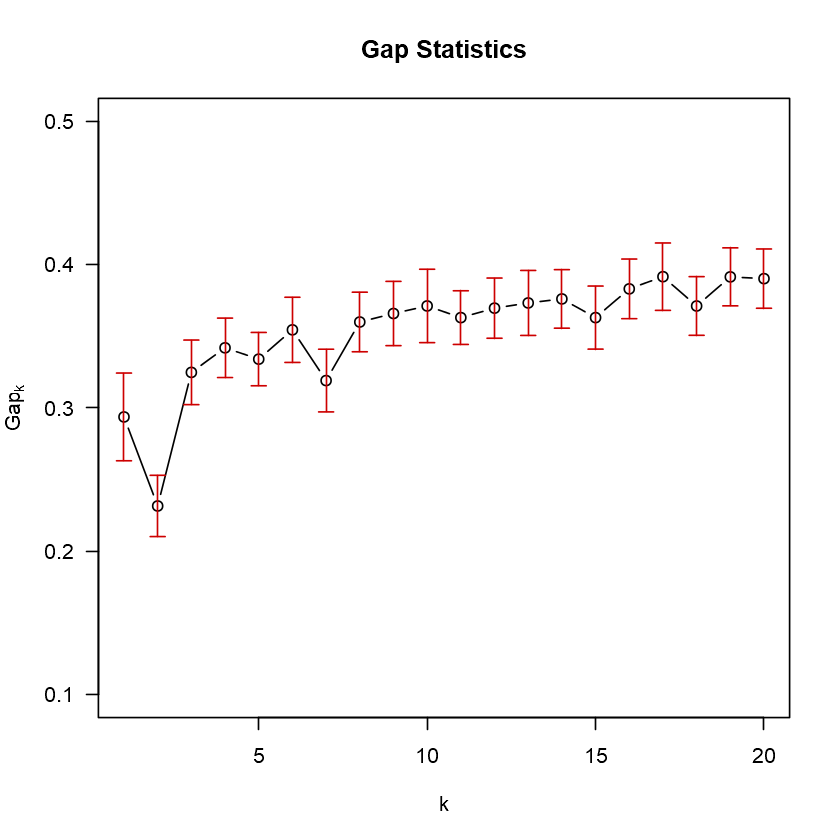

In [6]:
sc<- Clustexp(sc,cln=3,quiet=T)    #### K-means clustering to get three clusters
plotGap(sc)        ### Plotting gap statisticssc<- Clustexp(sc, clustnr=20,bootnr=50,metric="pearson",do.gap=T,SE.method="Tibs2001SEmax",SE.factor=.25,B.gap=50,cln=K,rseed=17000)

#### 2.1.1. Defining the Cells in the clusters generated by k-means clustering

In [7]:
sc<- comptSNE(sc,rseed=15555,quiet = TRUE)
cat("\t","     Cell-ID"," Cluster Number","\n")
sc@cpart

	      Cell-ID  Cluster Number 


G1  G1_1  G1_2  G1_3  G1_4  G1_5  G1_6  G1_7  G1_8  G1_9 G1_10 G1_11 G1_12 
    1     2     1     1     1     1     2     2     3     3     3     1     3 
G1_13 G1_14 G1_15 G1_16 G1_17 G1_18 G1_19 G1_20 G1_21 G1_22 G1_23 G1_24 G1_25 
    1     1     1     3     2     2     2     3     1     2     1     1     2 
G1_26 G1_27 G1_28 G1_29     S   S_1   S_2   S_3   S_4   S_5   S_6   S_7   S_8 
    3     2     2     2     2     2     2     2     2     2     2     1     2 
  S_9  S_10  S_11  S_12  S_13  S_14  S_15  S_16  S_17  S_18  S_19  S_20  S_21 
    2     2     2     2     1     2     1     2     1     1     2     2     2 
 S_22  S_23  S_24  S_25  S_26  S_27  S_28  S_29  S_30  S_31    G2  G2_1  G2_2 
    1     1     2     2     2     3     2     2     2     3     2     2     2 
 G2_3  G2_4  G2_5  G2_6  G2_7  G2_8  G2_9 G2_10 G2_11 G2_12 G2_13 G2_14 G2_15 
    3     1     1     2     2     2     1     3     2     1     2     3     1 
G2_16 G2_17 G2_18 G2_19 G2_20 G2_21 G2_22 G2_23 G2_24 G2_25 G2_26 G2_27 G2_28 
    1     1     2     2     2     1     3     1     2     3     3     2     2 
G2_29 G2_30 G2_31 
    1     2     2

#### 2.1.2- Evaluating the stability and consistancy of the clusters

PSCAN enables the robustness assessment of the detected clusters in terms of stability and consistency using Jaccard’s similarity statistics and silhouette coefficients. Jaccard’s similarity index provides a comparison of members among clusters to evaluate the stability of the clusters with a range from 0% to 100%. The higher the percentage, the more stable the cluster is. Silhouette coefficients estimate how close each sample in one cluster is to samples in the neighboring clusters, reflecting the consistency of each cluster with a range of [-1, 1]. The higher the cluster mean coefficient, the more consistent the cluster is.

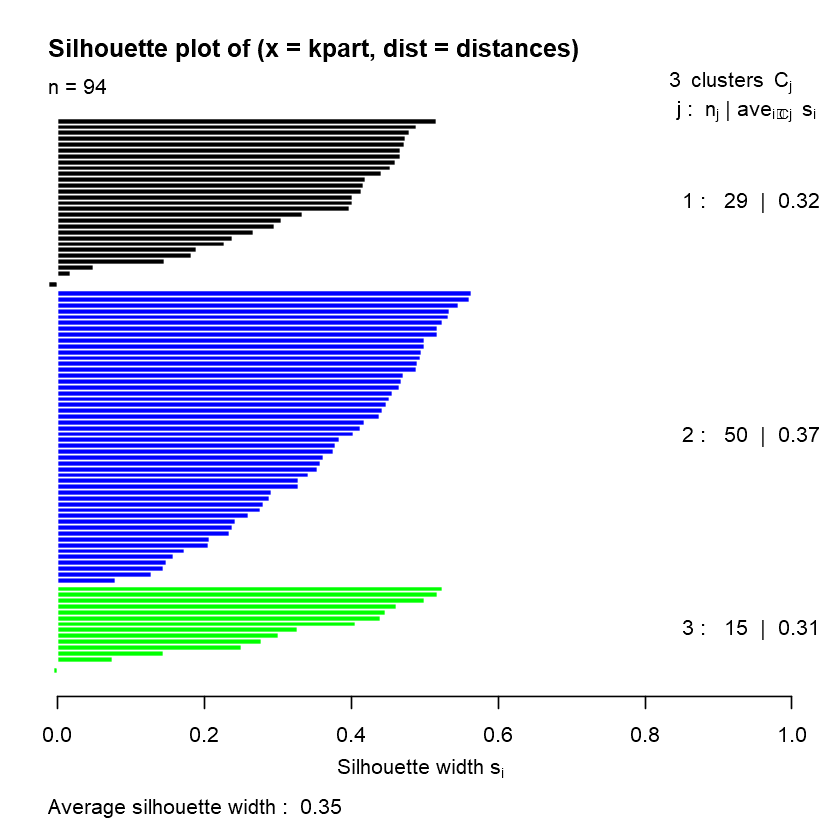

In [8]:
# Silhouette of k-means clusters
par(mar=c(6,2,4,2))
plotSilhouette(sc,K=3)       # K is the number of clusters

[1] 0.680 0.766 0.681

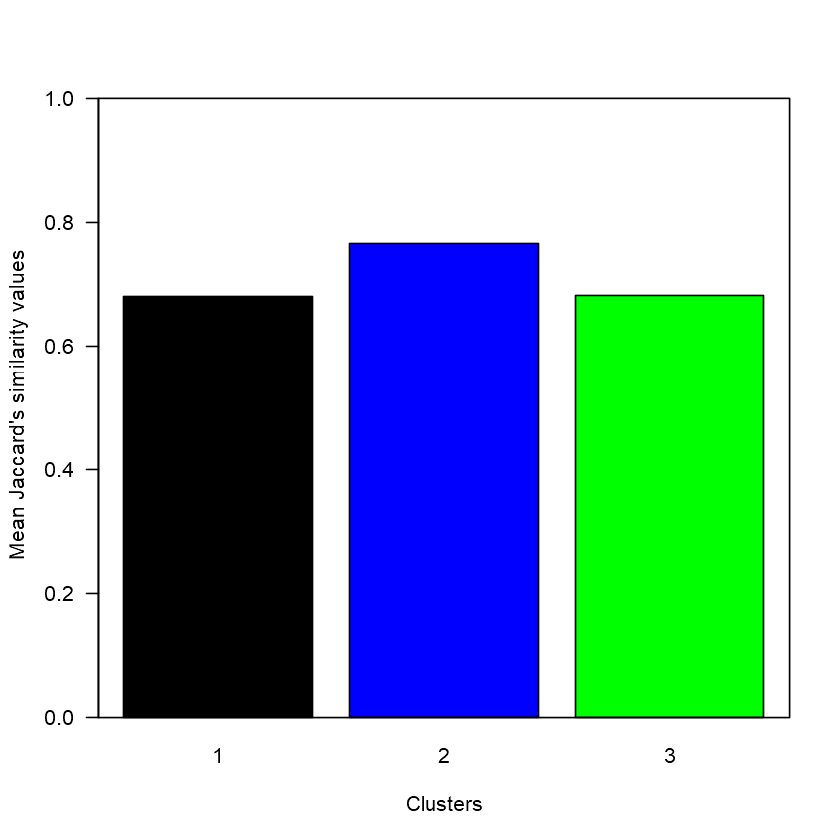

In [9]:
Jaccard(sc,Clustering="K-means", K=3, plot = TRUE)     # Jaccard of k-means clusters

#### 2.1.3. Cluster plotting using tSNE maps

Here you visualize the K-means clusters using t-distributed stochastic neighbor embedding (tSNE), which is a non-linear dimensionality reduction method that places neighbor cells close to each other. 

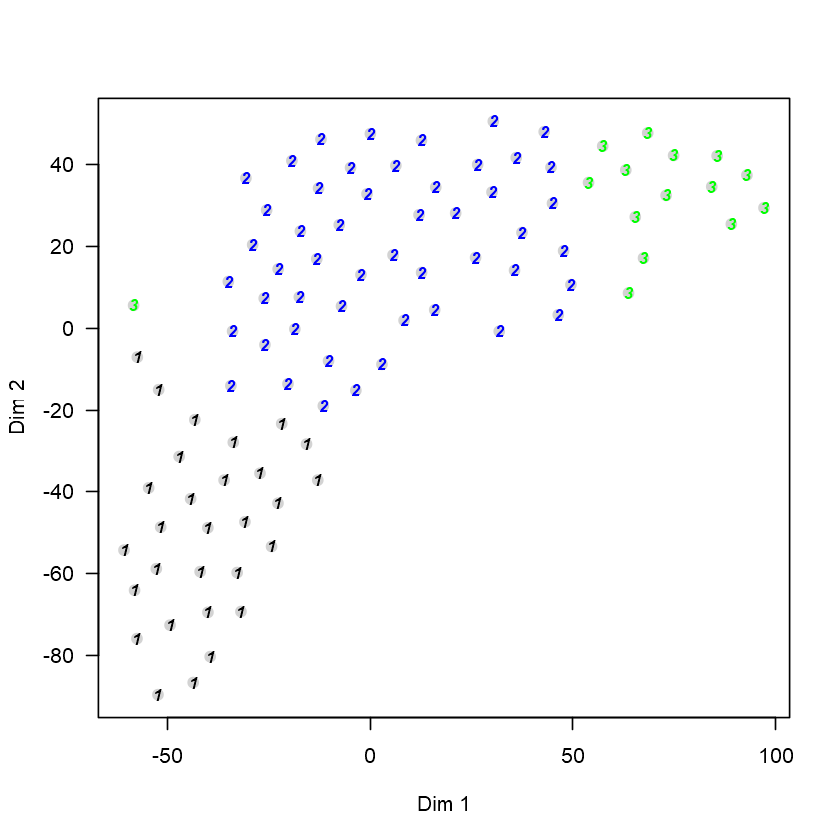

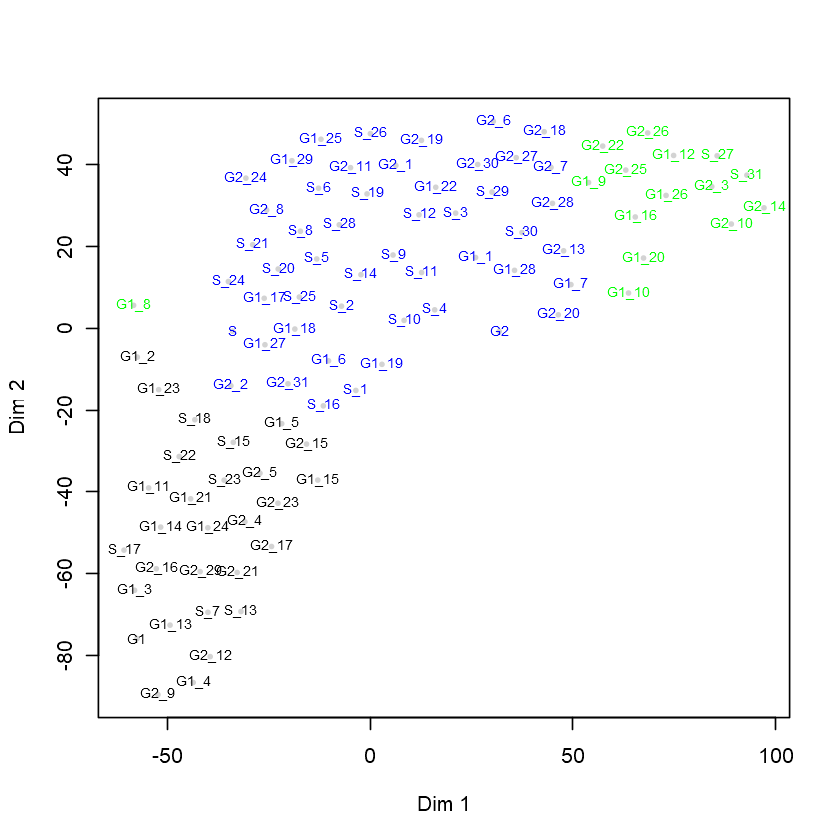

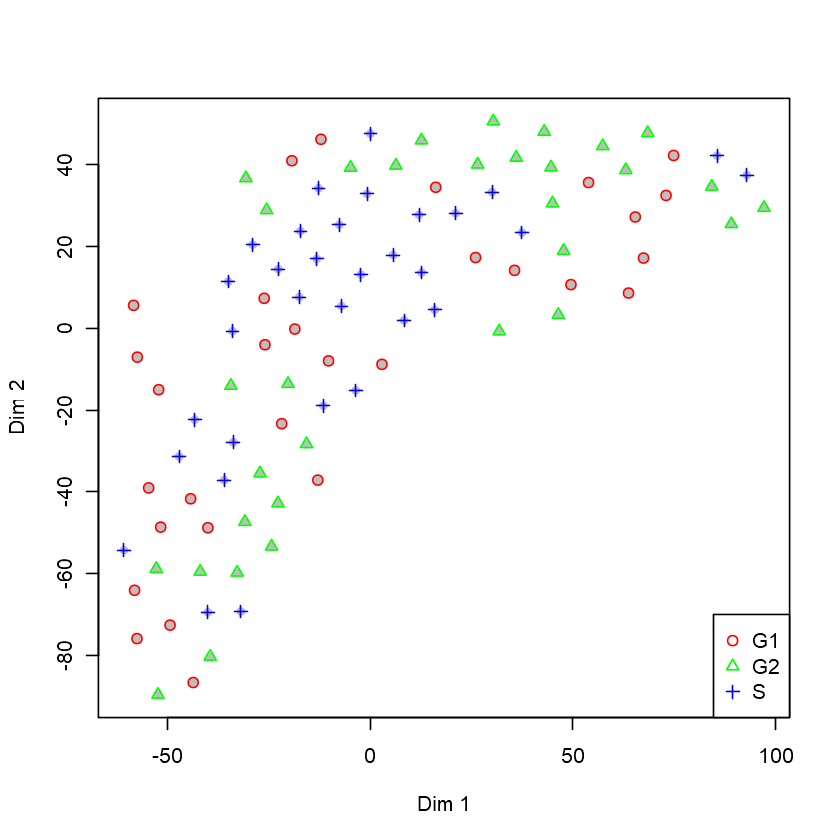

In [10]:
############ Plotting K-means clusters
plottSNE(sc)
plotKmeansLabelstSNE(sc)                                         # To plot the the ID of the cells in eacj cluster
plotSymbolstSNE(sc,types=sub("(\\_\\d+)$","", names(sc@ndata)))  # To plot the the ID of the cells in eacj cluster

### Defining outlier cells based on K-means Clustering

Outlier identification is implemented using a background model based on distribution of transcript counts within a cluster. Outlier cells are detected if the probability for that cell c that a minimum number of genes Gmin of observing total counts TGmin is less than a specific threshold Pthr, as given by the red dotted line. Outlier cells in K-means clusters can be detected by running the FindOutliersKM() function.
 
In case the user decided to remove outlier cells, the user should set RemovingOutliers to TRUE and then start from the beginning (Data Pre-processing). 

The following cells are considered as outlier cells: 1 13 22 
   G1 G1_12 G1_21 
    1    13    22 


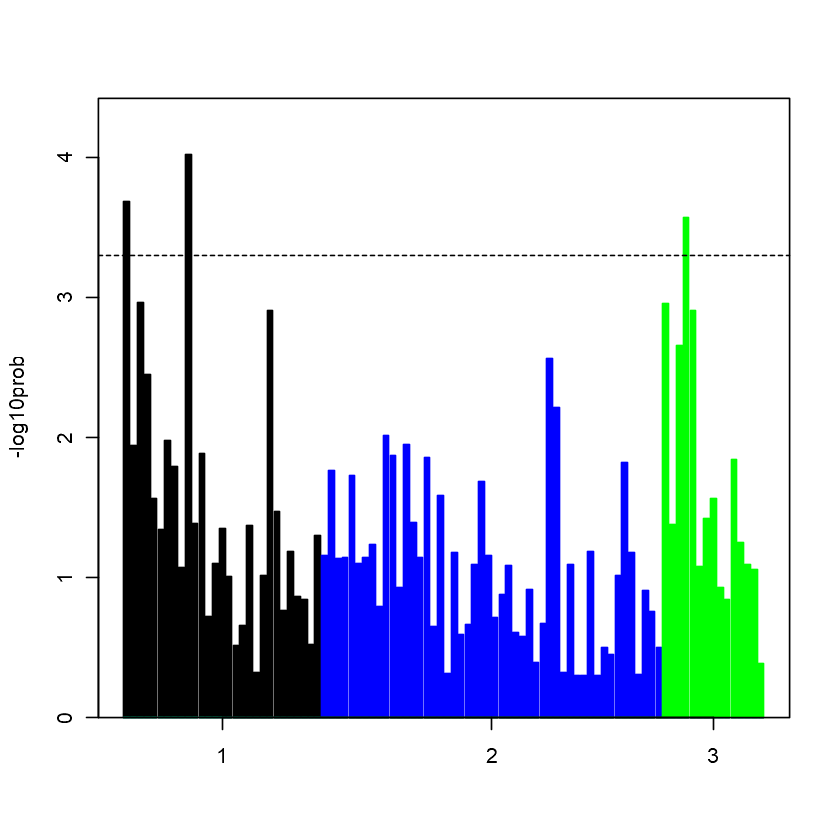

In [11]:
outlg<-round(length(sc@fdata[,1])/200)     # The cell will be considered as an outlier if it has a minimum of 0.5% of the number of filtered genes as outlier genes. 
Outliers<- FindOutliersKM(sc, K=3, outminc=5,outlg=outlg,probthr=.5*1e-3,thr=2**-(1:40),outdistquant=.75, plot = TRUE, quiet = FALSE)

RemovingOutliers=FALSE     
# RemovingOutliers=TRUE                    # Removing the defined outlier cells based on K-means Clustering

if(RemovingOutliers==TRUE){
    names(Outliers)=NULL
    Outliers
    DataSet=DataSet[-Outliers]
    dim(DataSet)
    colnames(DataSet)
    cat("Outlier cells were removed, now you need to start from the beginning")
}

#### 2.1.4. Cellular pseudo-time ordering based on k-means clusters 

   order orderID
1      1    S_13
2      2     S_7
3      3   G2_29
4      4   G2_21
5      5   G1_13
6      6    S_17
7      7   G2_23
8      8   G2_17
9      9    S_15
10    10   G1_24
11    11    G1_3
12    12    G2_4
13    13   G1_14
14    14    G2_5
15    15   G1_21
16    16   G1_11
17    17   G2_16
18    18    S_18
19    19    G1_4
20    20    S_23
21    21   G2_12
22    22    S_22
23    23      G1
24    24   G1_15
25    25   G2_15
26    26    G1_5
27    27   G1_23
28    28    G2_9
29    29    G1_2
30    30    G2_2
31    31    S_16
32    32       S
33    33    S_24
34    34   G1_18
35    35   G1_27
36    36   G2_31
37    37    S_25
38    38     S_2
39    39      G2
40    40   G2_24
41    41    S_21
42    42   G1_17
43    43    S_14
44    44     S_1
45    45   G1_19
46    46    S_20
47    47    G2_8
48    48    G1_6
49    49     S_8
50    50     S_5
51    51    G2_1
52    52    S_28
53    53     S_6
54    54    S_10
55    55     S_4
56    56     S_3
57    57   G2_19
58    58   G1_

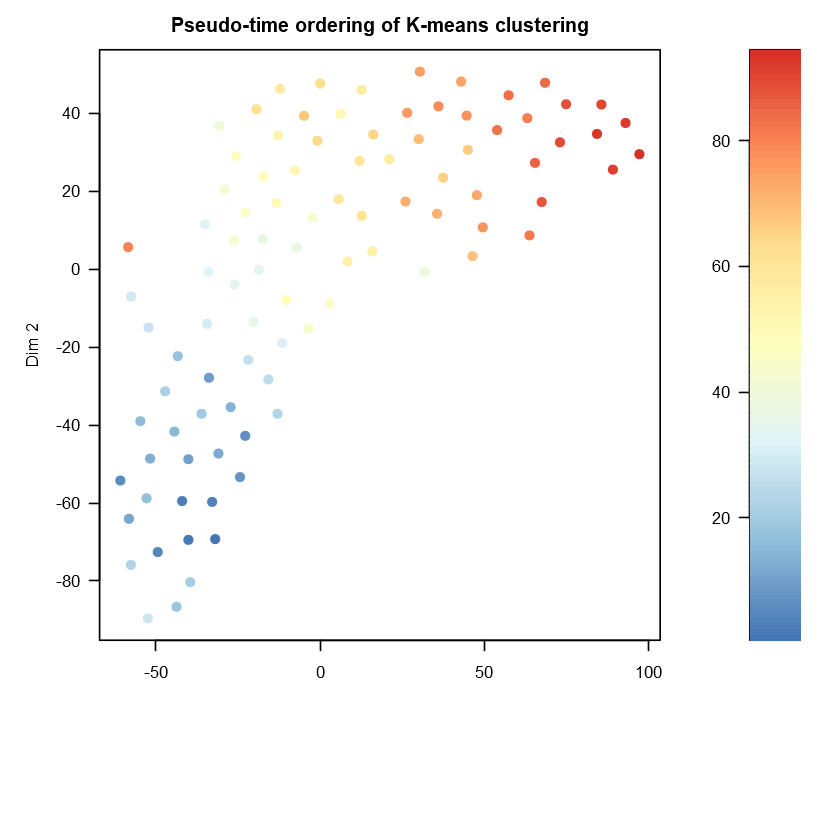

In [12]:
sc<-KmeanOrder(sc,quiet = FALSE, export = TRUE)
plotOrderKMtsne(sc)

#### 2.1.5 Plotting the K-means clusters in heatmap

The similarities between single-cells were computed by Euclidean distances of Pearson transcriptome correlation matrix. Based on these similarities, a heatmap portrayal of cell-to-cell distances was plotted using Euclidean as the distance measure and the single linkage as the clustering method, cluster centers were ordered by hierarchic clustering. 

[1] 3 1 2

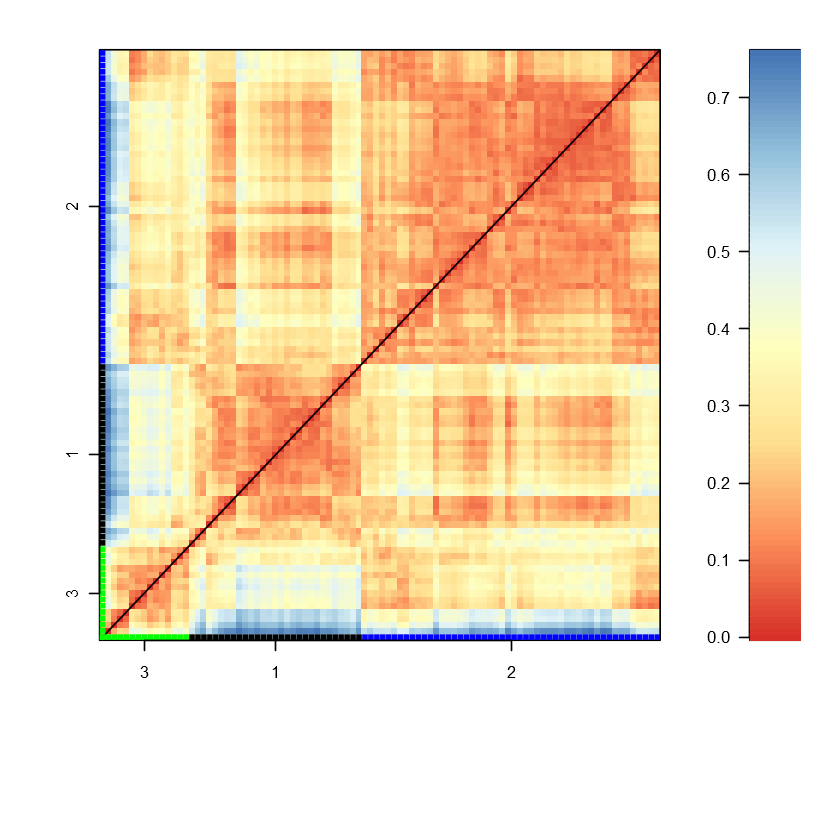

In [13]:
KMclustheatmap(sc,hmethod="single", plot = TRUE) 

#### 2.1.6 Plotting the gene expression of a particular gene in a tSNE map

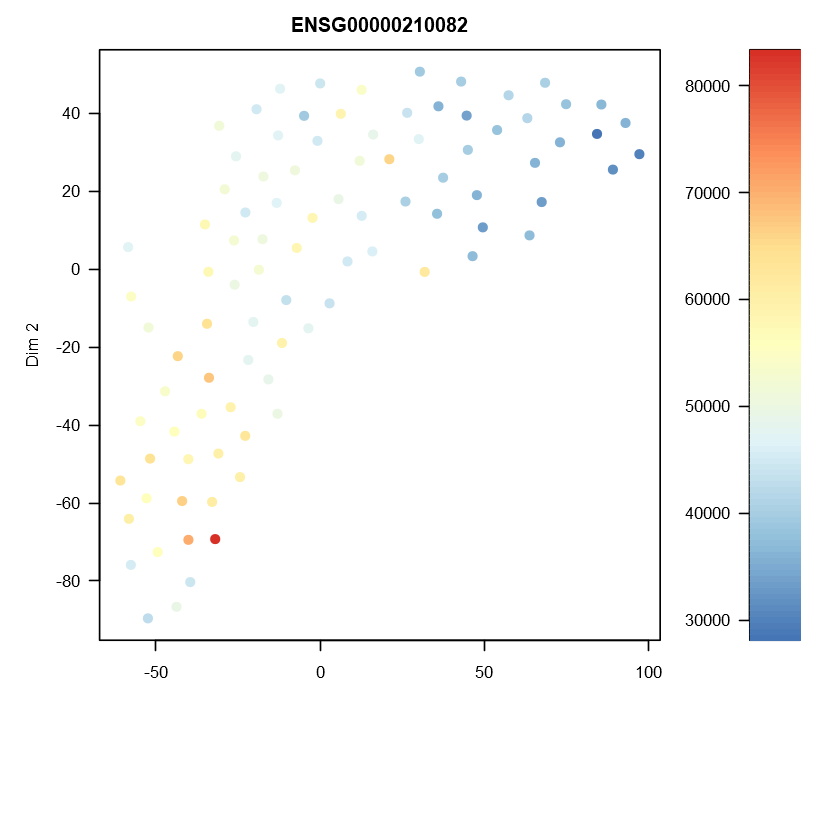

In [14]:
g='ENSG00000210082'                   #### Plotting the expression of  MT-RNR2
plotExptSNE(sc,g)

## 3. Determining differentially expressed genes (DEGs) For K-means Clustering

Differentially expressed genes between individual clusters are identified using the significance analysis of sequencing data (SAMseq), which is a new function in significance analysis of microarrays (Li and Tibshirani 2011) in the samr package v2.0 (Tibshirani et all., 2015). SAMseq is a non-parametric statistical function dependent on Wilcoxon rank statistic that equalizes the sizes of the library by a resampling method accounting for the various sequencing depths. The analysis is implemented over the pure raw dataset that has the unnormalized expression read counts after excluding the ERCCs. Furthermore, DEGs in each cluster comparing to all the remaining clusters are determined using binomial differential expression, which is based on binomial counting statistics.

![DIsccBIO](KM2.png)

## 3.1 Identifying DEGs using SAMseq

The user can define DEGs between all clusters generated by either K-means or model based clustering by applying the “DEGanalysis” function. Another alternative is to define DEGs between particular clusters generated by K-means clustering by applying the “DEGanalysis2clust” function. The outcome of these two functions is a list of two components:
- The first component is a data frame showing the Ensembl gage name and the symbole of the detected DEGs
- The second component is table showing the comparisons, Target cluster, Number of genes and the File name. This component will be used for the downstream analysis.

### 3.1.1 Determining DEGs between two particular clusters

The results of DEGs are saved in your directory 
Low-regulated genes in the CL3 in CL1 VS CL3
The results of DEGs are saved in your directory 
Up-regulated genes in the CL3 in CL1 VS CL3


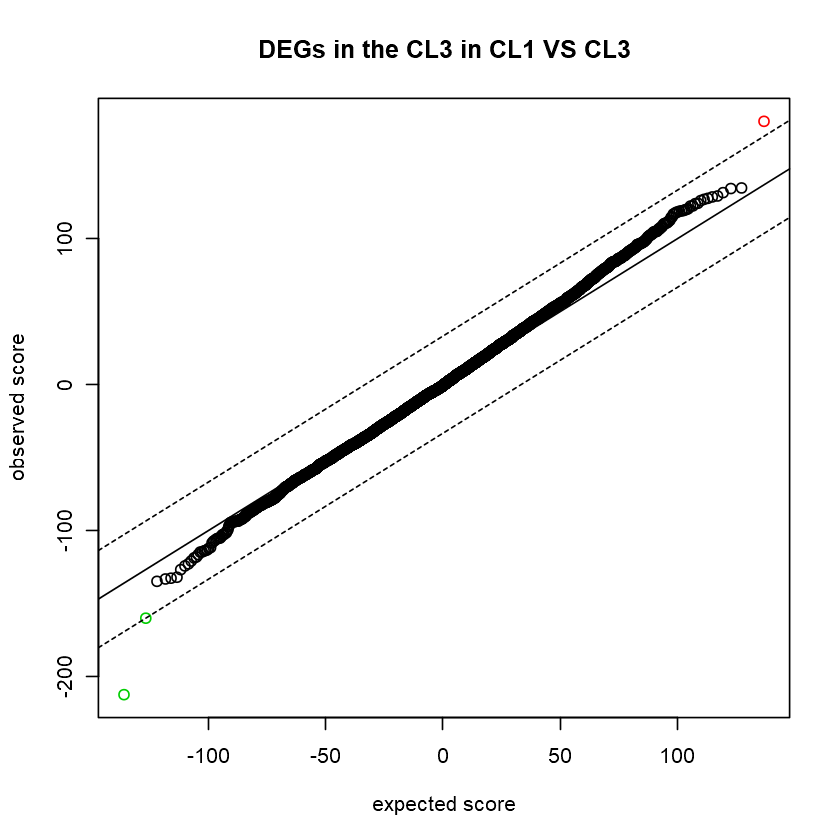

In [15]:
####### differential expression analysis between cluster 1 and cluster 3 of the Model-Based clustering using FDR of 0.05
cdiff<-DEGanalysis2clust(sc,Clustering="K-means",K=3,fdr=0.05,name="Name",First="CL1",Second="CL3",export = TRUE,quiet=T)     

In [16]:
#### To show the result table
head(cdiff[[1]])                  # The first component 
head(cdiff[[2]])                  # The second component 

DEGsE           DEGsS 
[1,] ENSG00000198888 ND1   
[2,] ENSG00000210082 MTRNR2
[3,] ENSG00000075624 ACTB

Comparisons Target cluster Gene number File name                          
1 CL1 VS CL3  CL3            1           Up-regulated-NameCL3inCL1VSCL3.csv 
2 CL1 VS CL3  CL1            1           Low-regulated-NameCL1inCL1VSCL3.csv
  Gene number File name                          
1 2           Low-regulated-NameCL3inCL1VSCL3.csv
2 2           Up-regulated-NameCL1inCL1VSCL3.csv

### 3.1.2 Determining DEGs between all clusters


##                                         ¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤ Running this cell will overwrite the previous one ¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤

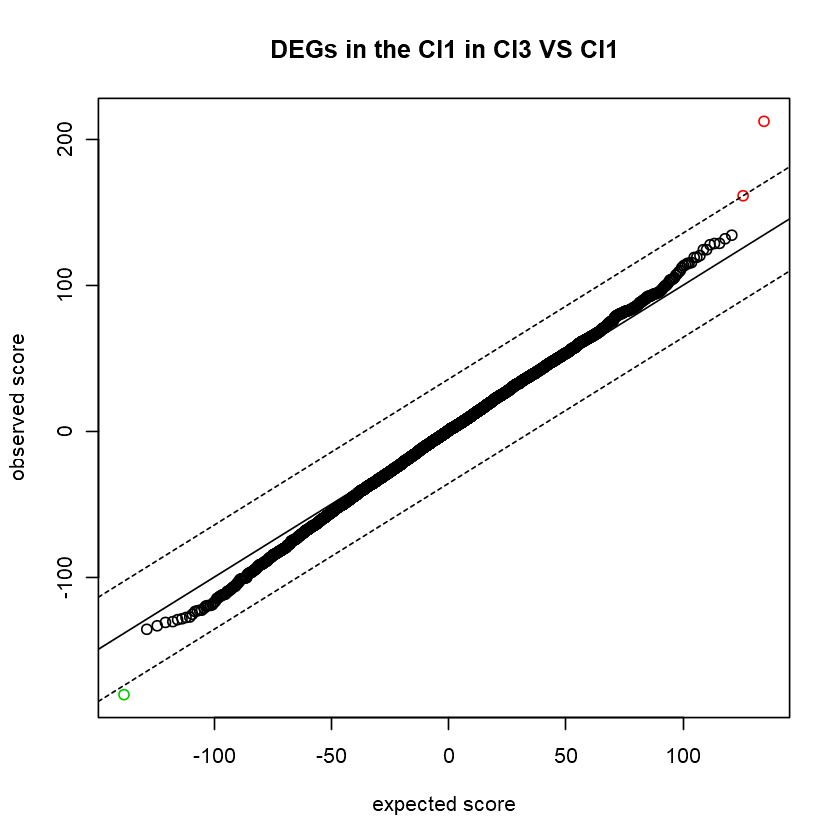

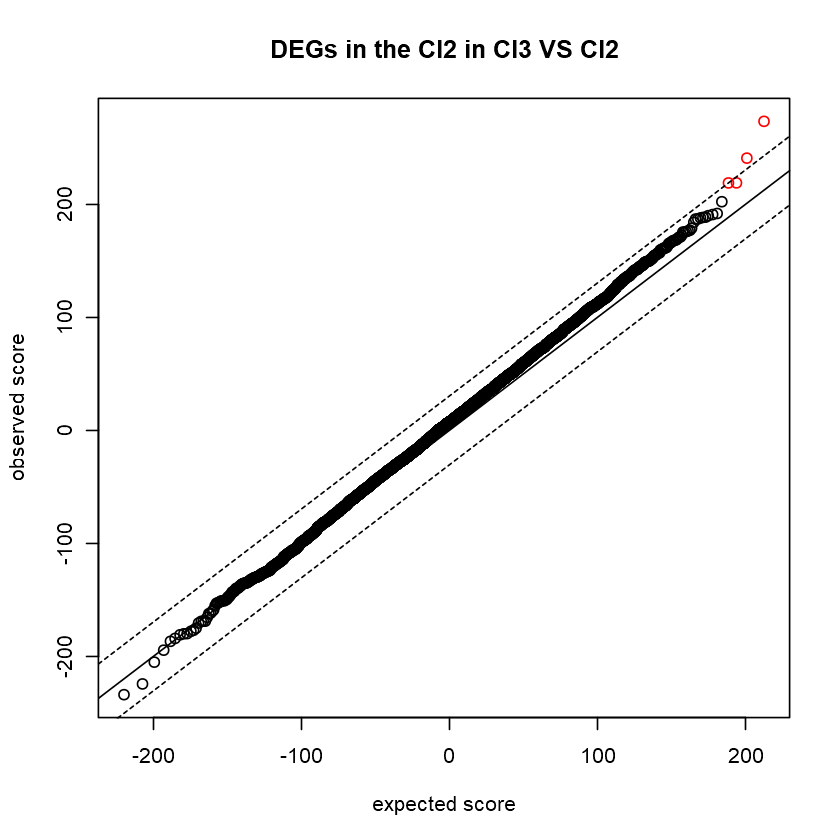

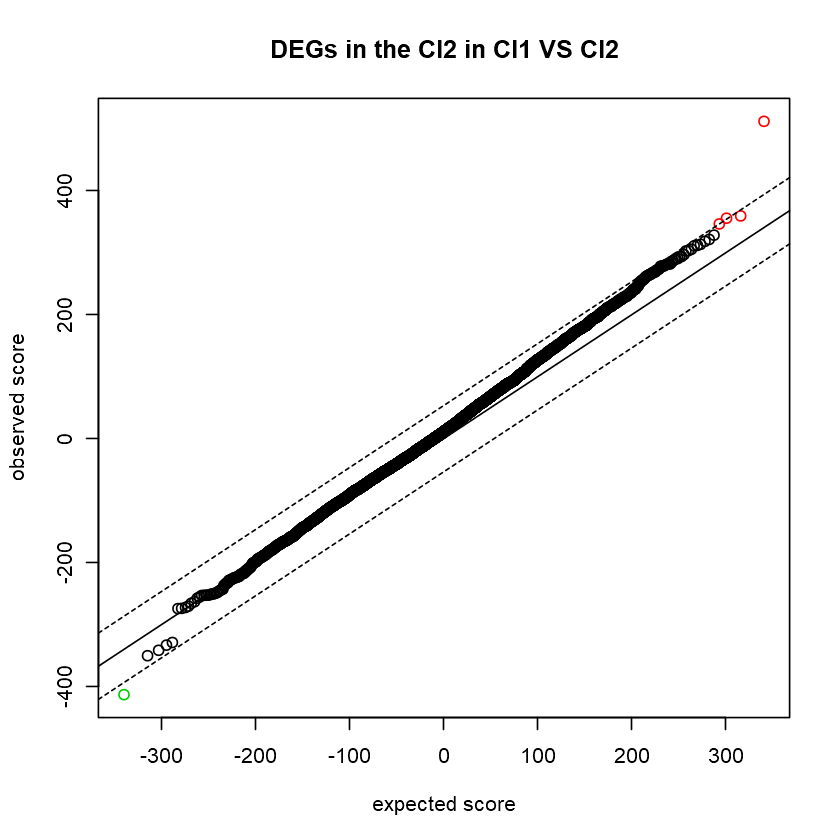

In [17]:
cdiff<-DEGanalysis(sc,Clustering="K-means",K=3,fdr=0.05,name="all_clusters",export = TRUE,quiet=T)   ####### differential expression analysis between all clusters

In [18]:
#### To show the result table
head(cdiff[[1]])                  # The first component 
head(cdiff[[2]])                  # The second component

DEGsE           DEGsS 
[1,] ENSG00000075624 ACTB  
[2,] ENSG00000198888 ND1   
[3,] ENSG00000210082 MTRNR2
[4,] ENSG00000168297 PXK   
[5,] ENSG00000198888 ND1   
[6,] ENSG00000210082 MTRNR2

Comparisons Target cluster Gene number
1 Cl3 VS Cl1  Cl1            2          
2 Cl3 VS Cl2  Cl2            4          
3 Cl1 VS Cl2  Cl2            4          
4 Cl3 VS Cl1  Cl3            2          
5 Cl3 VS Cl2  Cl3            4          
6 Cl1 VS Cl2  Cl1            4          
  File name                                   Gene number
1 Up-regulated-all_clustersCl1inCl3VSCl1.csv  1          
2 Up-regulated-all_clustersCl2inCl3VSCl2.csv  0          
3 Up-regulated-all_clustersCl2inCl1VSCl2.csv  1          
4 Low-regulated-all_clustersCl3inCl3VSCl1.csv 1          
5 Low-regulated-all_clustersCl3inCl3VSCl2.csv 0          
6 Low-regulated-all_clustersCl1inCl1VSCl2.csv 1          
  File name                                  
1 Low-regulated-all_clustersCl1inCl3VSCl1.csv
2 Low-regulated-all_clustersCl2inCl3VSCl2.csv
3 Low-regulated-all_clustersCl2inCl1VSCl2.csv
4 Up-regulated-all_clustersCl3inCl3VSCl1.csv 
5 Up-regulated-all_clustersCl3inCl3VSCl2.csv 
6 Up-regulated-all_clustersCl1inCl1VSCl2.csv

#### 3.2 Identifying DEGs using binomial differential expression

The function KMClustDiffGenes identifies differentially regulated genes for each cluster of the K-means clustering in 
comparison to the ensemble of all cells. It returns a list with a data.frame element for each cluster that contains the mean expression across all cells not in the cluster (mean.ncl) and in the cluster (mean.cl), the fold-change in the cluster versus all remaining cells (fc), and the p-value for differential expression between all cells in a cluster and all remaining cells. The p-value is computed based on the overlap of negative binomials fitted to the count distributions within the two groups akin to DESeq.

In [19]:
cdiffBinomial<-KMClustDiffGenes(sc,K=3,fdr=.01,,quiet=T)    ########## Binomial differential expression analysis
#### To show the result table
head(cdiffBinomial[[1]])                  # The first component 
head(cdiffBinomial[[2]])                  # The second component

DEGsE           DEGsS
[1,] ENSG00000011426 ANLN 
[2,] ENSG00000011485 PPP5C
[3,] ENSG00000022267 FHL1 
[4,] ENSG00000047849 MAP4 
[5,] ENSG00000051180 RAD51
[6,] ENSG00000052802 MSMO1

Target Cluster VS                 Gene number File name           Gene number
1 Cluster 1      Remaining Clusters  34         Up-DEG-cluster1.csv  71        
2 Cluster 2      Remaining Clusters   7         Up-DEG-cluster2.csv   7        
3 Cluster 3      Remaining Clusters 357         Up-DEG-cluster3.csv 295        
  File name            
1 Down-DEG-cluster1.csv
2 Down-DEG-cluster2.csv
3 Down-DEG-cluster3.csv

### Plotting the DEGs

Volcano plots are used to readily show the DEGs by plotting significance versus fold-change on the y and x axes, respectively.

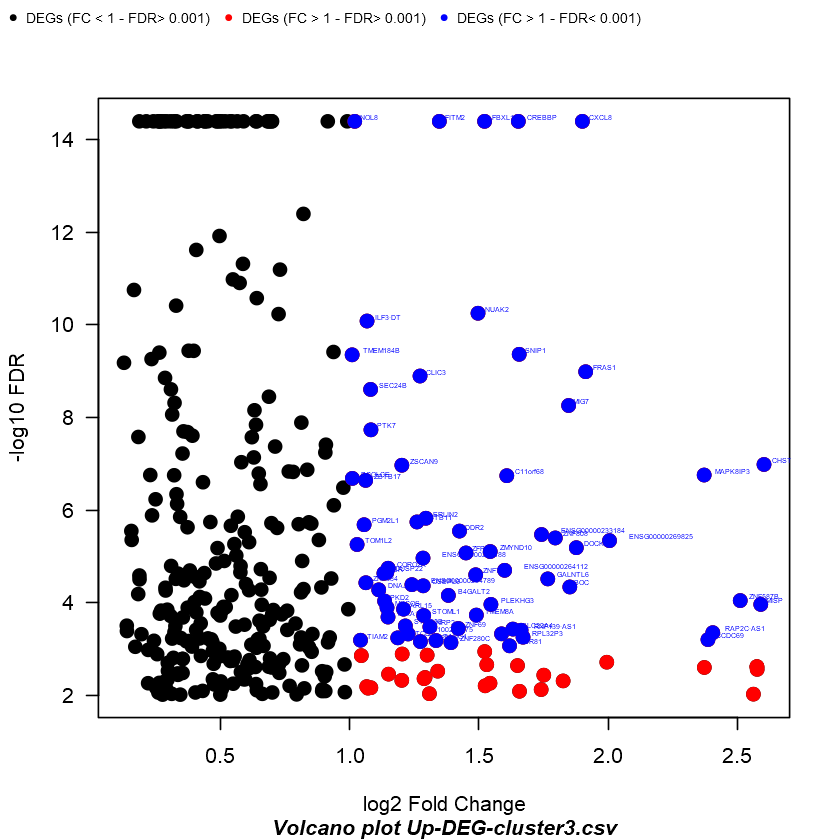

In [20]:
name<-cdiffBinomial[[2]][3,4]    ############ Selecting the DEGs' table  ##############
U<-read.csv(file=paste0(name),head=TRUE,sep=",")
Vplot<-VolcanoPlot(U,value=0.001,name=name,FS=.3,fc=1)

#### In case the output of this function is an error "Error in plot.window(...): need finite 'ylim' values", the adj should be set to TRUE
### In case the user would like to get the names of the significant DEGs then FS should be set to a value of 0.3 or higher.

## 4. Identifying biomarkers (decision trees and networking analysis) 

There are several methods to identify biomarkers, among them are decision trees and hub detection through networking analysis. The outcome of STRING analysis is stored in tab separated values (TSV) files. These TSV files served as an input to check both the connectivity degree and the betweenness centrality, which reflects the communication flow in the defined PPI networks 

![DIsccBIO](KM3.png)

Decision trees are one of the most efficient classification techniques in biomarkers discovery. Here we use it to predict the sub-population of a target cell based on transcriptomic data. Two types of decision trees can be performed: classification and regression trees (CART) and J48. The decision tree analysis is implemented over a training dataset, which consisted of the DEGs obtained by either SAMseq or the binomial differential expression. The performance of the generated trees can be evaluated for error estimation by ten-fold cross validation assessment using the "J48DTeval" and "RpartEVAL" functions. The decision tree analysis requires the dataset to be class vectored by applying the “ClassVectoringDT” function.

In [21]:
#sigDEG<-cdiff[[1]]             # DEGs gene list from SANseq
sigDEG<-cdiffBinomial[[1]]      # DEGs gene list from Binomial analysis
First="CL1"
Second="CL3"
DATAforDT<-ClassVectoringDT(sc,Clustering="K-means",K=3,First=First,Second=Second,sigDEG)

The DEGs filtered normalized dataset contains:
 Genes: 703 
 cells: 44

### 4.1. J48 Decision Tree

J48 pruned tree
------------------

MTRNR2 <= 41518.323682: CL3 (14.0)
MTRNR2 > 41518.323682: CL1 (30.0/1.0)

Number of Leaves  : 	2

Size of the tree : 	3




=== Summary ===

Correctly Classified Instances          43               97.7273 %
Incorrectly Classified Instances         1                2.2727 %
Kappa statistic                          0.9486
Mean absolute error                      0.0439
Root mean squared error                  0.1482
Relative absolute error                  9.7301 %
Root relative squared error             31.2661 %
Total Number of Instances               44     

=== Confusion Matrix ===

  a  b   <-- classified as
 29  0 |  a = CL1
  1 14 |  b = CL3

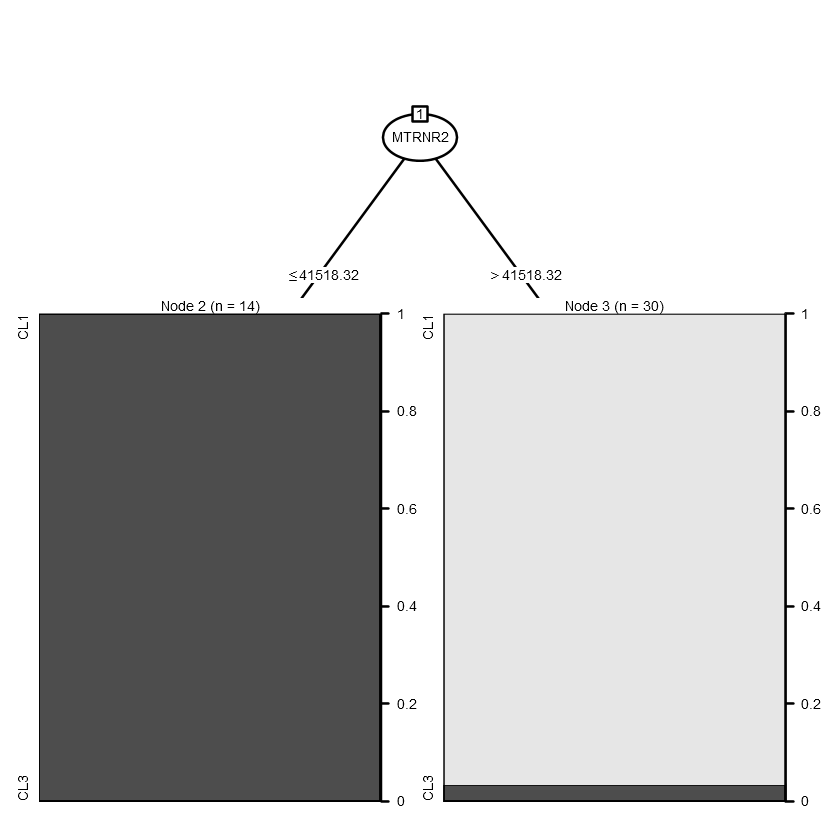

In [22]:
j48dt<-J48DT(DATAforDT)
summary(j48dt) 

#### 4.1.1. Evaluating the performance of the J48 Decision Tree

In [23]:
j48dt<-J48DTeval(DATAforDT,num.folds=10,First=First,Second=Second)

Fold 1 of 10 
Fold 2 of 10 
Fold 3 of 10 
Fold 4 of 10 
Fold 5 of 10 
Fold 6 of 10 
Fold 7 of 10 
Fold 8 of 10 
Fold 9 of 10 
Fold 10 of 10 
TP FN FP TN 
29  0  2 13 
             CL1 CL3
PredictedCL1  29   2
PredictedCL3   0  13
J48 SN: 1
J48 SP: 0.8666667
J48 ACC: 0.9545455
J48 MCC: 0.9004181


### 4.2. RPART Decision Tree

n= 44 

node), split, n, loss, yval, (yprob)
      * denotes terminal node

1) root 44 15 CL1 (0.65909091 0.34090909)  
  2) MTRNR2>=41999.57 30  1 CL1 (0.96666667 0.03333333)  
    4) ZMYND10< 265.1516 29  0 CL1 (1.00000000 0.00000000) *
    5) ZMYND10>=265.1516 1  0 CL3 (0.00000000 1.00000000) *
  3) MTRNR2< 41999.57 14  0 CL3 (0.00000000 1.00000000) *


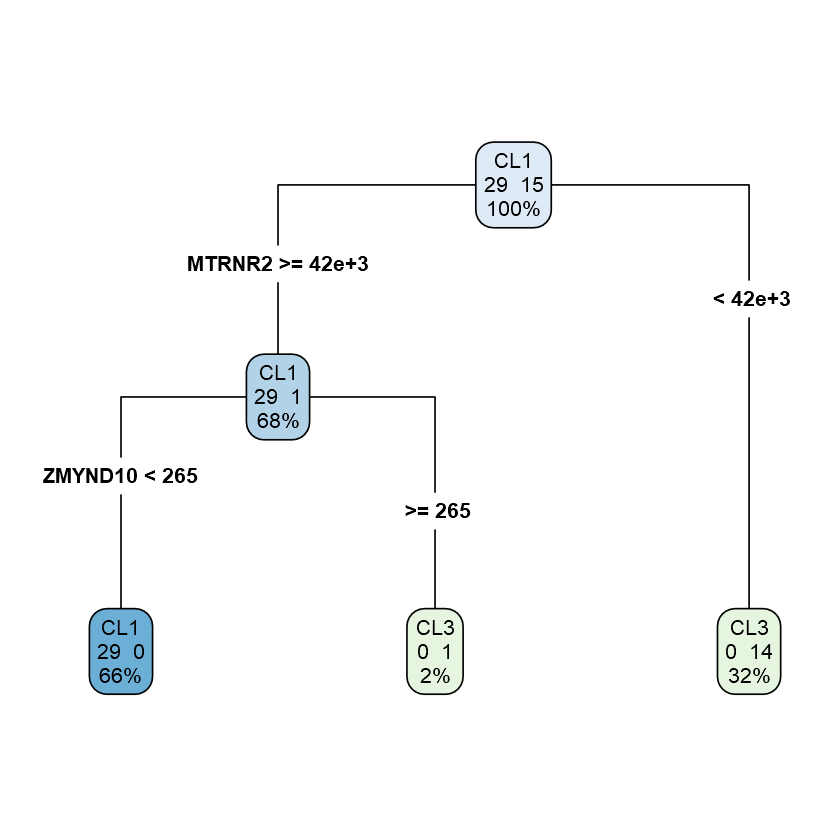

In [24]:
rpartDT<-RpartDT(DATAforDT)

#### 4.2.1. Evaluating the performance of the RPART Decision Tree

In [25]:
rpartEVAL<-RpartEVAL(DATAforDT,num.folds=10,First=First,Second=Second)

Fold 1 of 10 
Fold 2 of 10 
Fold 3 of 10 
Fold 4 of 10 
Fold 5 of 10 
Fold 6 of 10 
Fold 7 of 10 
Fold 8 of 10 
Fold 9 of 10 
Fold 10 of 10 
TP FN FP TN 
28  1  1 14 
             CL1 CL3
PredictedCL1  28   1
PredictedCL3   1  14
Rpart SN: 0.9655172
Rpart SP: 0.9333333
Rpart ACC: 0.9545455
Rpart MCC: 0.8988506


### 4.3. Networking Analysis

To define protein-protein interactions (PPI) over a list of genes, STRING-api is used. The outcome of STRING analysis was stored in tab separated values (TSV) files. These TSV files served as an input to check both the connectivity degree and the betweenness centrality, which reflects the communication flow in the defined PPI networks.

### 4.3.1 All DEGs

In [26]:
DEGs="All DEGs"
FileName=paste0(DEGs)

data<-cdiffBinomial[[1]] [,2]           # DEGs gene list from Binomial analysis (taking only the firat 100 genes)
#data<-cdiff[[1]] [,2]                  # From the table of the differential expression analysis between all pairs of clusters

ppi<-PPI(data,FileName)

networking<-NetAnalysis(ppi)
networking                            ##### In case the Examine response components = 200 and an error "linkmat[i, ]" appeared, that means there are no PPI.

Examine response components = 200 	 200 means successful 


No encoding supplied: defaulting to UTF-8.


Number of nodes:  599 
Number of links:  3811 
Link Density:  6.36227 
The connectance of the graph:  0.01063925 
Mean Distences 3.139471 
Average Path Length 3.139471 
 


names   degree betweenness
360 CDK1    98     3008.24190 
469 UBC     83     1295.95300 
205 ACTB    79     7222.34268 
452 HSPA8   78     1083.23581 
96  PLK1    76     1967.53094 
3   AURKA   75       30.73708 
24  CCNB1   74      644.13068 
267 CDC20   71     1878.80675 
311 PCNA    64      947.97115 
183 CTNNB1  63     4927.14221 
200 UBE2C   63     1836.67082 
86  CCNB2   60      862.11581 
97  TPX2    57      674.00738 
131 TYMS    56     2095.02780 
333 RAD51   56      849.26818 
265 KIF2C   55      915.76361 
501 CDC6    54        0.00000 
52  CENPE   53      441.27647 
102 BUB1    53      239.12898 
117 MCM7    53     1493.85870 
216 RRM2    53      713.52270 
238 NEK2    52      841.55123 
432 PPP2CA  52      916.27054 
262 ORC1    51      667.93200 
254 TTK     50      187.10483 
358 KIF20A  50      337.40603 
98  RRM1    49     1042.36292 
109 FEN1    49      673.41000 
346 PTTG1   49      130.81490 
17  DLGAP5  48       14.67405 
... ...     ...    ...        
557 TMSB10  1      0          
560 NRBP1   1      0          
562 KLF10   1      0          
563 HSDL1   1      0          
565 DAGLB   1      0          
566 NUAK2   1      0          
569 GORAB   1      0          
572 EXTL3   1      0          
573 ZNF202  1      0          
575 MOCOS   1      0          
576 ZBTB11  1      0          
577 STARD7  1      0          
578 ZNF350  1      0          
579 REEP3   1      0          
580 REEP4   1      0          
581 DNER    1      0          
582 IL13RA1 1      0          
584 MLX     1      0          
585 ZNF292  1      0          
586 FAM98A  1      0          
587 RCBTB2  1      0          
588 MNS1    1      0          
589 BCDIN3D 1      0          
590 NRP2    1      0          
591 ZNF789  1      0          
592 THUMPD1 1      0          
595 GYG1    1      0          
596 CRHBP   1      0          
597 ABCB8   1      0          
598 TENM3   1      0

Examine response components = 200 	 200 means successful 

 You can see the network with high resolution by clicking on the following link: 
 https://string-db.org/api/highres_image/network?identifiers=CDK1%0dUBC%0dACTB%0dHSPA8%0dPLK1%0dAURKA%0dCCNB1%0dCDC20%0dPCNA%0dCTNNB1%0dUBE2C%0dCCNB2%0dTPX2%0dTYMS%0dRAD51%0dKIF2C%0dCDC6%0dCENPE%0dBUB1%0dMCM7%0dRRM2%0dNEK2%0dPPP2CA%0dORC1%0dTTK&species=9606

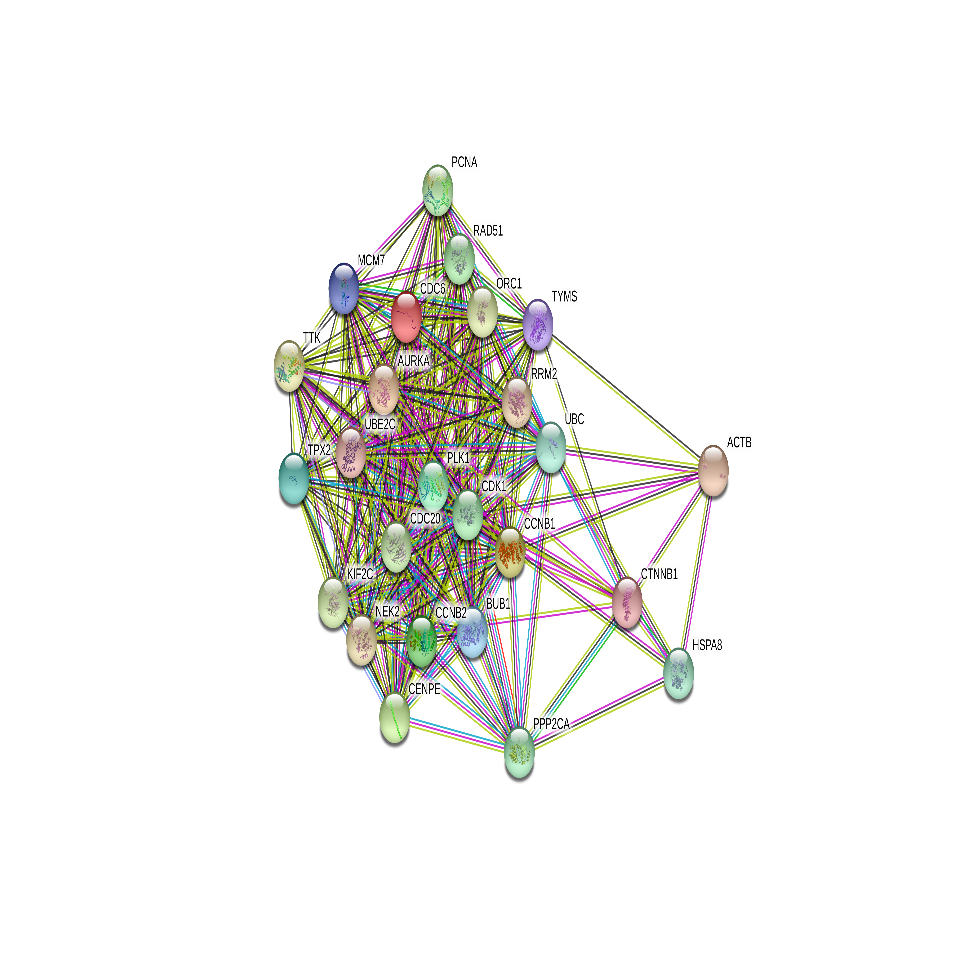

In [27]:
data=networking[1:25,1]              # plotting the network of the top 25 highly connected genes 
network<-Networking(data,FileName,plot_width = 25, plot_height = 10)

### 4.3.2 Particular set of DEGs 

Examine response components = 200 	 200 means successful 


No encoding supplied: defaulting to UTF-8.


Number of nodes:  21 
Number of links:  34 
Link Density:  1.619048 
The connectance of the graph:  0.08095238 
Mean Distences 1.028571 
Average Path Length 1.028571 
 


names   degree betweenness
1  SQLE    5      0          
2  HMGCR   5      0          
5  DHCR7   5      0          
6  FDPS    5      0          
12 IDI1    5      0          
17 MSMO1   5      0          
19 RPS3    5      0          
7  MT-CO1  4      0          
8  PTGS1   4      0          
9  MT-ATP6 4      0          
10 MT-ND1  4      0          
3  MCM7    3      0          
18 CDC6    3      0          
4  PABPC1  2      1          
13 RAD51   2      0          
15 CDKN1A  2      0          
11 S100A10 1      0          
14 PAIP2   1      0          
16 DSN1    1      0          
20 DAGLB   1      0          
21 SDCBP   1      0

Examine response components = 200 	 200 means successful 

 You can see the network with high resolution by clicking on the following link: 
 https://string-db.org/api/highres_image/network?identifiers=RAD51%0dMSMO1%0dIDI1%0dPABPC1%0dCDC6%0dSQLE%0dHMGCR%0dPAIP2%0dCDKN1A%0dRTN3%0dSDCBP%0dUSO1%0dADM%0dRPS3%0dNPAT%0dDSN1%0dFDPS%0dERAP2%0dDAGLB%0dZNF143%0dMCM7%0dB2M%0dDHCR7%0dMX2%0dZNF292%0dFAM111B%0dZNF136%0dS100A10%0dCOX1%0dND1%0dATP6%0dCOX3%0dMTRNR2%0dMTRNR1&species=9606

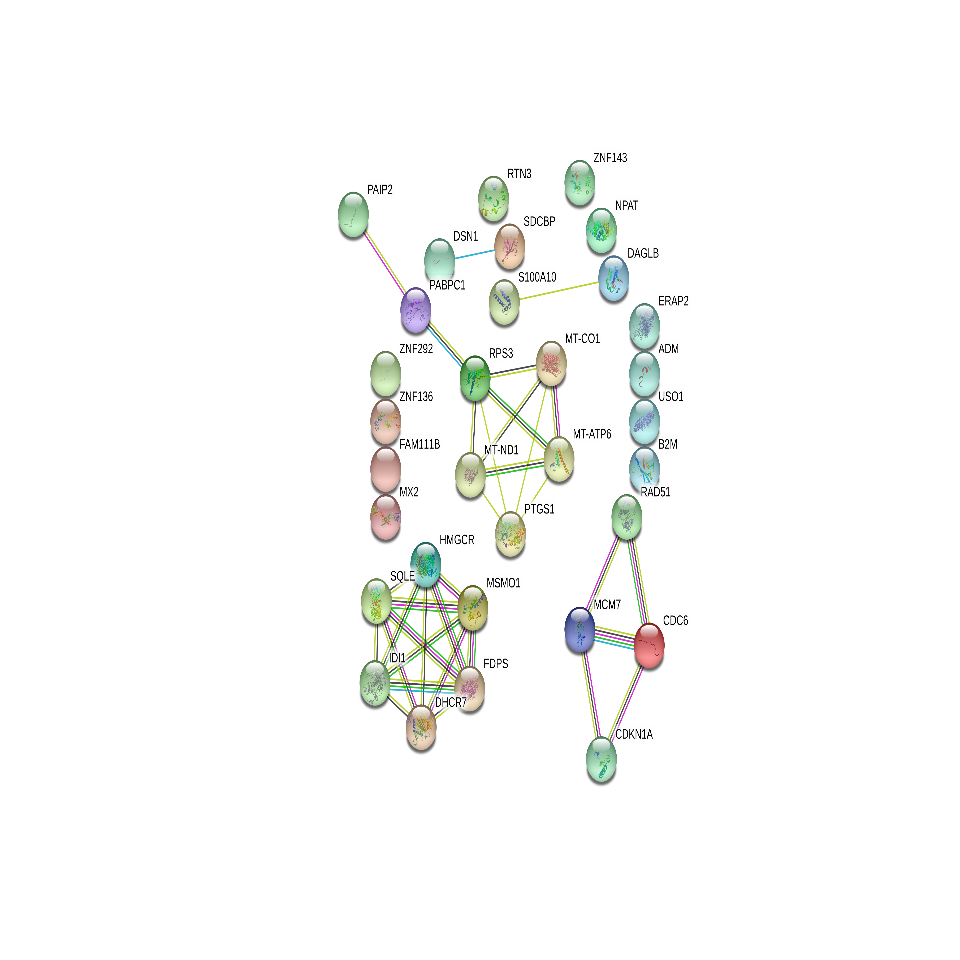

In [28]:
############ Selecting the DEGs' table  ##############
DEGs=cdiffBinomial[[2]][1,4]     # Up-regulated genes in cluster 1 (from the Binomial analysis)
#DEGs=cdiff[[2]][1,4]             # Up-regulated genes in cluster 1 (from SAMseq)
FileName=paste0(DEGs)

data<-read.csv(file=paste0(DEGs),head=TRUE,sep=",")
data<-data[,3]

ppi<-PPI(data,FileName)

networking<-NetAnalysis(ppi)
networking                            ##### In case the Examine response components = 200 and an error "linkmat[i, ]" appeared, that means there are no PPI.

network<-Networking(data,FileName)

### 4.4 Gene Enrichment Analysis

In [29]:
dbs <- listEnrichrDbs()
head(dbs)
#print(dbs)

geneCoverage genesPerTerm libraryName                     
1 13362         275         Genome_Browser_PWMs             
2 27884        1284         TRANSFAC_and_JASPAR_PWMs        
3  6002          77         Transcription_Factor_PPIs       
4 47172        1370         ChEA_2013                       
5 47107         509         Drug_Perturbations_from_GEO_2014
6 21493        3713         ENCODE_TF_ChIP-seq_2014         
  link                                                     numTerms
1 http://hgdownload.cse.ucsc.edu/goldenPath/hg18/database/ 615     
2 http://jaspar.genereg.net/html/DOWNLOAD/                 326     
3                                                          290     
4 http://amp.pharm.mssm.edu/lib/cheadownload.jsp           353     
5 http://www.ncbi.nlm.nih.gov/geo/                         701     
6 http://genome.ucsc.edu/ENCODE/downloads.html             498

In [30]:
############ Selecting the DEGs' table  ##############
DEGs=cdiffBinomial[[2]][1,4]     # Up-regulated genes in cluster 1 (from the Binomial analysis)
#DEGs=cdiff[[2]][1,4]              # Up-regulated genes in cluster 1 (from SAMseq)

data<-read.csv(file=paste0(DEGs),head=TRUE,sep=",")
data<-as.character(data[,3])

dbs <- c("KEGG_2013","GO_Molecular_Function_2015", "GO_Biological_Process_2015")
enriched <- enrichr(data, dbs)
KEGG_2013<-enriched[[1]][,c(1,2,3,9)]
GO_Molecular_Function_2015<-enriched[[2]][,c(1,2,3,9)]
GO_Biological_Process_2015<-enriched[[3]][,c(1,2,3,9)]

GEA<-rbind(KEGG_2013,GO_Molecular_Function_2015,GO_Biological_Process_2015)
GEA

Uploading data to Enrichr... Done.
  Querying KEGG_2013... Done.
  Querying GO_Molecular_Function_2015... Done.
  Querying GO_Biological_Process_2015... Done.
Parsing results... Done.


Term                                                                                                                                                                             
1   HSA00100 BIOSYNTHESIS OF STEROIDS                                                                                                                                                
2   HSA00900 TERPENOID BIOSYNTHESIS                                                                                                                                                  
3   HSA00190 OXIDATIVE PHOSPHORYLATION                                                                                                                                               
4   HSA04110 CELL CYCLE                                                                                                                                                              
5   HSA00130 UBIQUINONE BIOSYNTHESIS                                                                                                                                                 
6   HSA05219 BLADDER CANCER                                                                                                                                                          
7   HSA05214 GLIOMA                                                                                                                                                                  
8   HSA04115 P53 SIGNALING PATHWAY                                                                                                                                                   
9   HSA05218 MELANOMA                                                                                                                                                                
10  HSA05212 PANCREATIC CANCER                                                                                                                                                       
11  HSA05220 CHRONIC MYELOID LEUKEMIA                                                                                                                                                
12  HSA04612 ANTIGEN PROCESSING AND PRESENTATION                                                                                                                                     
13  HSA04012 ERBB SIGNALING PATHWAY                                                                                                                                                  
14  HSA05215 PROSTATE CANCER                                                                                                                                                         
15  HSA03010 RIBOSOME                                                                                                                                                                
16  protein C-terminus binding (GO:0008022)                                                                                                                                          
17  translation regulator activity (GO:0045182)                                                                                                                                      
18  oxidoreductase activity, acting on paired donors, with incorporation or reduction of molecular oxygen, NAD(P)H as one donor, and incorporation of one atom of oxygen (GO:0016709)
19  damaged DNA binding (GO:0003684)                                                                                                                                                 
20  single-stranded DNA binding (GO:0003697)                                                                                                                                         
21  DNA-dependent ATPase activity (GO:0008094)                                                                                                                                       


## 2.2. Model-Based clustering

![DIsccBIO](MB1.png)

Model-based clustering assumes that the data are generated by a model and attempts to recover the original model from the data to define cellular clusters.

#### 2.2.1. Defining the Cells in the clusters generated by model-based clustering

In [31]:
sc <- Exprmclust(sc,K =3,reduce = TRUE,quiet = TRUE) 
cat("\t","     Cell-ID"," Cluster Number","\n")
sc@MBclusters$clusterid


	      Cell-ID  Cluster Number 


G1  G1_1  G1_2  G1_3  G1_4  G1_5  G1_6  G1_7  G1_8  G1_9 G1_10 G1_11 G1_12 
    1     1     1     1     1     1     1     1     1     1     1     1     1 
G1_13 G1_14 G1_15 G1_16 G1_17 G1_18 G1_19 G1_20 G1_21 G1_22 G1_23 G1_24 G1_25 
    1     1     1     1     1     1     3     1     1     1     1     1     2 
G1_26 G1_27 G1_28 G1_29     S   S_1   S_2   S_3   S_4   S_5   S_6   S_7   S_8 
    1     3     1     1     3     1     3     3     3     3     1     1     3 
  S_9  S_10  S_11  S_12  S_13  S_14  S_15  S_16  S_17  S_18  S_19  S_20  S_21 
    1     3     3     3     3     1     1     3     1     3     3     3     3 
 S_22  S_23  S_24  S_25  S_26  S_27  S_28  S_29  S_30  S_31    G2  G2_1  G2_2 
    3     1     3     3     3     3     3     3     1     3     1     2     1 
 G2_3  G2_4  G2_5  G2_6  G2_7  G2_8  G2_9 G2_10 G2_11 G2_12 G2_13 G2_14 G2_15 
    3     2     2     2     2     1     3     1     3     1     2     2     1 
G2_16 G2_17 G2_18 G2_19 G2_20 G2_21 G2_22 G2_23 G2_24 G2_25 G2_26 G2_27 G2_28 
    1     2     2     2     2     1     2     2     1     2     3     2     2 
G2_29 G2_30 G2_31 
    1     1     1

#### 2.2.2. Cluster plotting using PCA and tSNE maps

To visualize the detected clusters, two common dimensionality reduction tools are implemented: tSNE map and principal component analysis (PCA), which is a linear dimensionality reduction method that preserves the global structure and shows how the measurements themselves are related to each other.  

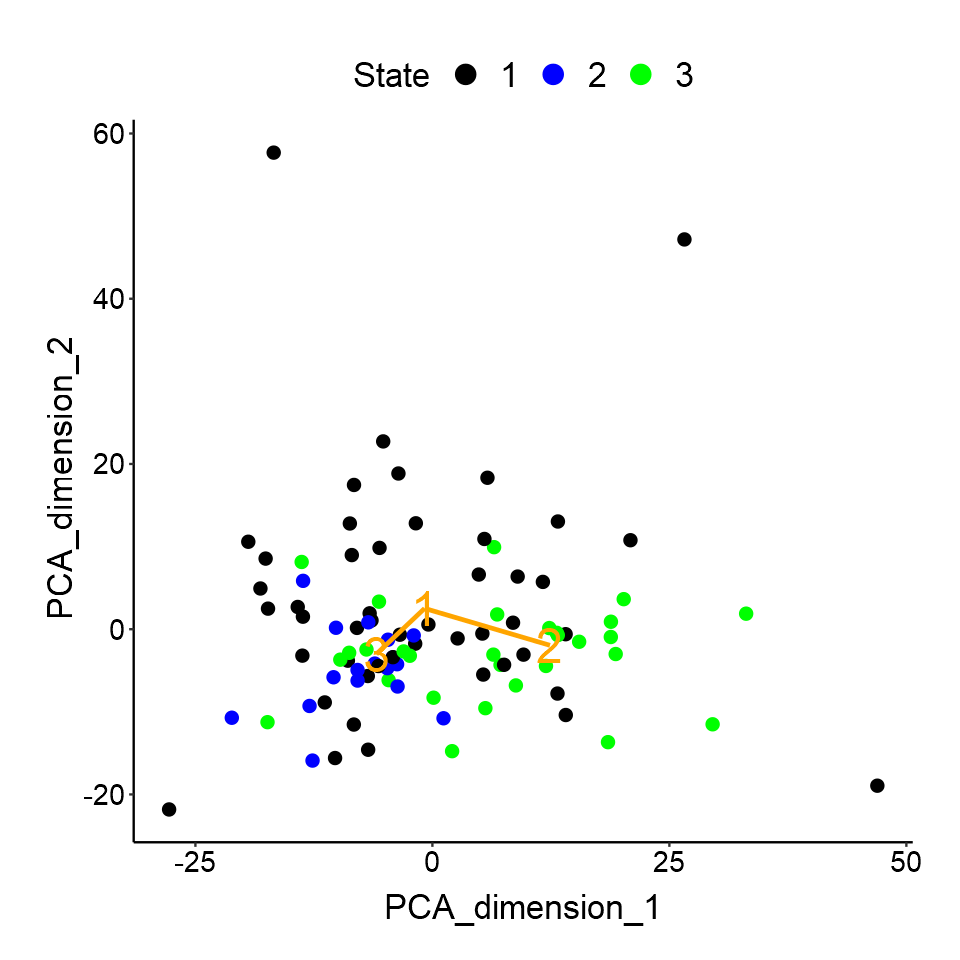

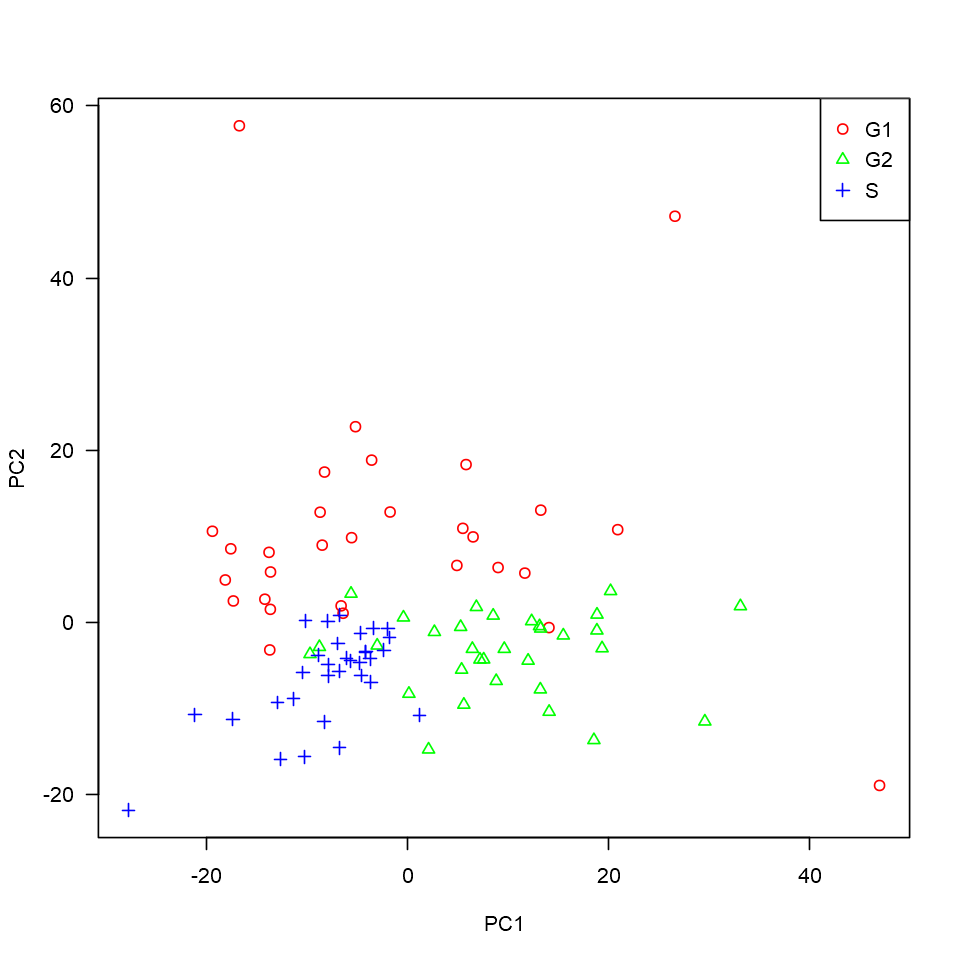

In [32]:
PlotmclustMB(sc)
PCAplotSymbols(sc)

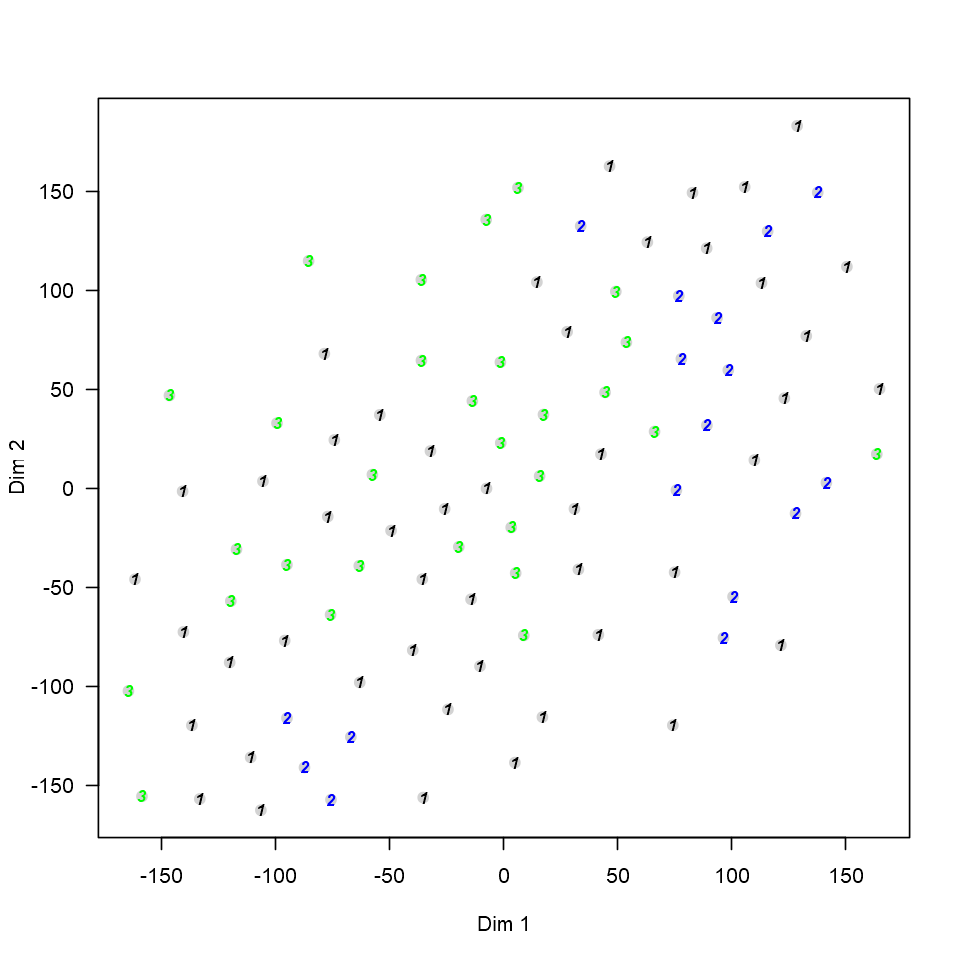

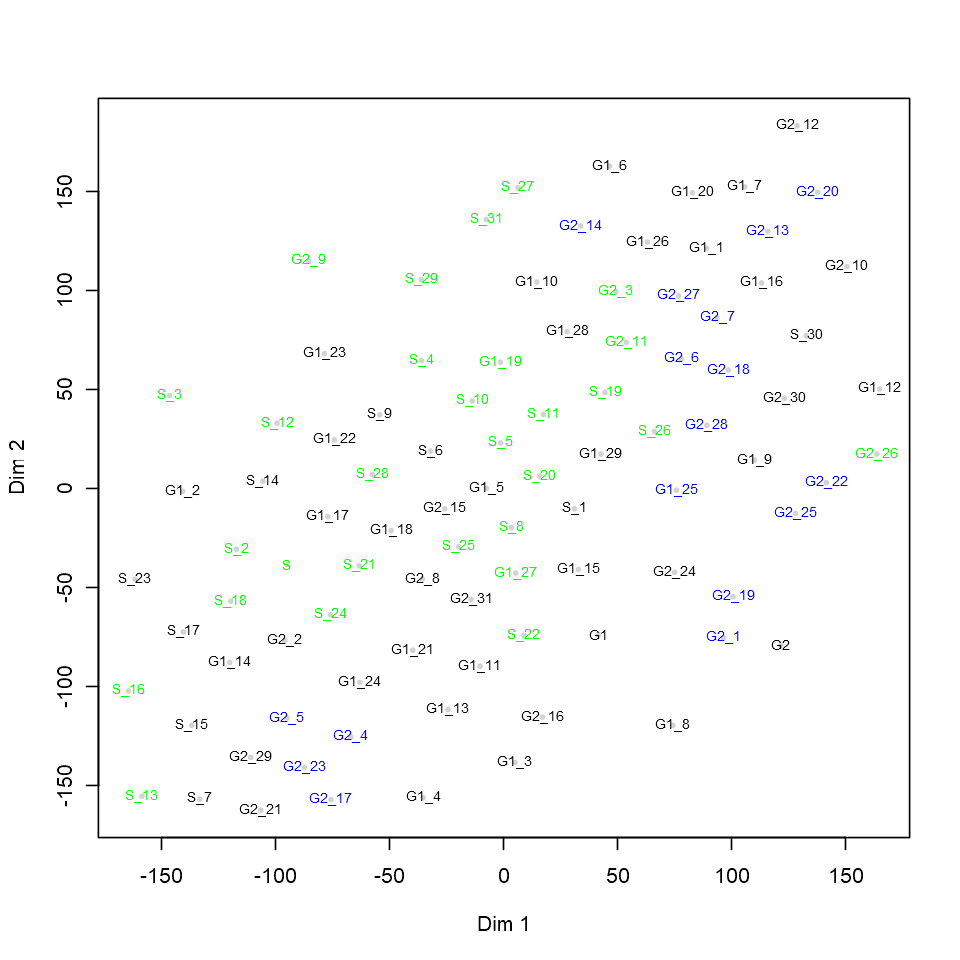

In [33]:
# Plotting the model-based clusters in tSNE maps
sc<- comptsneMB(sc,rseed=15555,quiet = TRUE)
plottsneMB(sc,K=3)
plotMBLabelstSNE(sc)

#### 2.2.3. Evaluating the stability and consistancy of the clusters

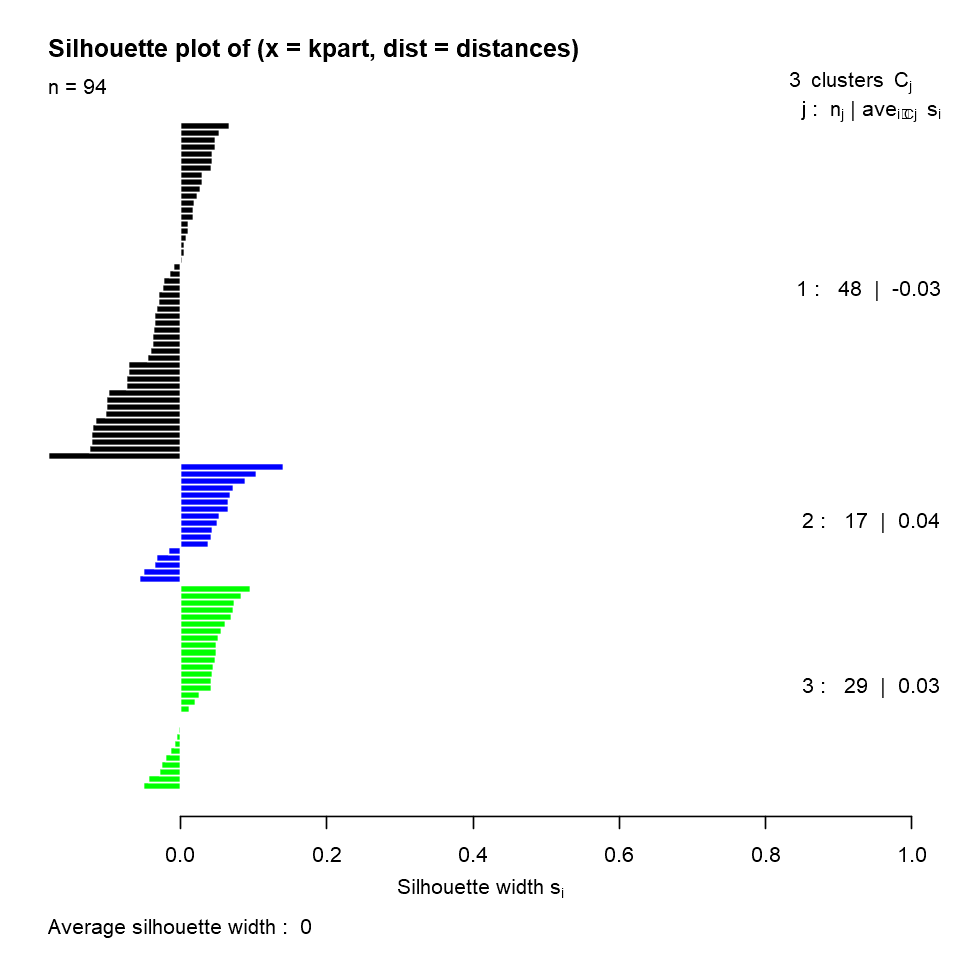

In [34]:
# Silhouette of Model-based clusters
par(mar=c(6,2,4,2))
plotsilhouetteMB(sc,K=3)

[1] 0.660 0.766 0.812

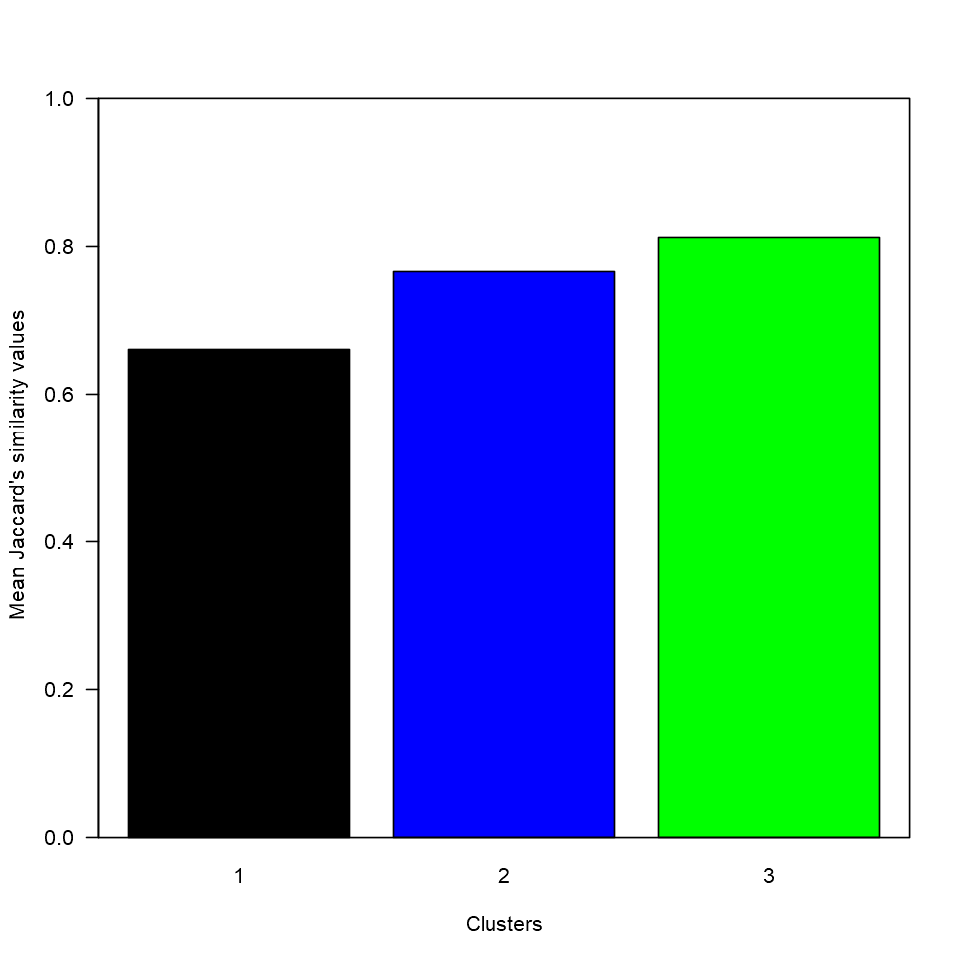

In [35]:
sc<- Clustexp(sc,cln=3,quiet=T)                  
Jaccard(sc,Clustering="MB", K=3, plot = TRUE)    # Jaccard of Model based clusters

### Defining outlier cells based on Model-Based Clustering

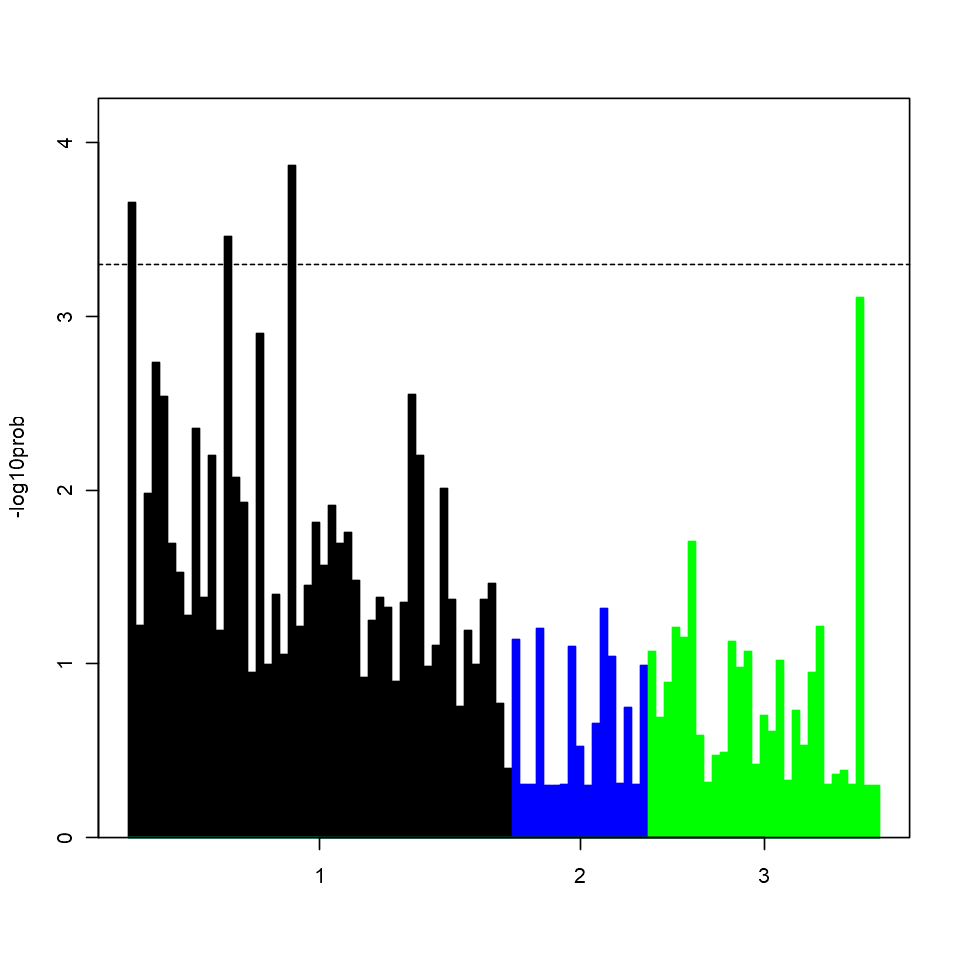

In [36]:
outlg<-round(length(sc@fdata[,1])/200)     # The cell will be considered as an outlier if it has a minimum of 0.5% of the number of filtered genes as outlier genes. 
Outliers<- FindOutliersMB(sc, K=3, outminc=5,outlg=outlg,probthr=.5*1e-3,thr=2**-(1:40),outdistquant=.75, plot = TRUE, quiet = T)

RemovingOutliers=FALSE     
# RemovingOutliers=TRUE                    # Removing the defined outlier cells based on K-means Clustering

if(RemovingOutliers==TRUE){
    names(Outliers)=NULL
    Outliers
    DataSet=DataSet[-Outliers]
    dim(DataSet)
    colnames(DataSet)
    cat("Outlier cells were removed, now you need to start from the beginning")
}

### 2.2.4. Cellular pseudo-time ordering based on Model-based clusters

In [37]:
sc<-MB_Order(sc,quiet = FALSE, export = TRUE)

   order orderID
1      1   G2_20
2      2   G2_17
3      3   G2_14
4      4   G2_13
5      5   G2_19
6      6   G1_25
7      7    G2_4
8      8   G2_18
9      9   G2_22
10    10   G2_23
11    11    G2_5
12    12    G2_7
13    13   G2_28
14    14   G2_25
15    15    G2_6
16    16   G2_27
17    17    G2_1
18    18   G1_16
19    19      G2
20    20   G2_10
21    21   G2_12
22    22   G2_29
23    23    G1_7
24    24   G2_24
25    25    G1_4
26    26    G1_9
27    27   G1_26
28    28    G2_8
29    29    G1_1
30    30   G2_30
31    31   G2_31
32    32   G1_20
33    33   G1_15
34    34   G1_29
35    35    G1_3
36    36   G1_21
37    37    G1_8
38    38   G1_13
39    39      G1
40    40   G1_12
41    41   G1_28
42    42   G1_23
43    43   G2_16
44    44   G1_17
45    45   G2_15
46    46   G1_11
47    47   G1_18
48    48   G1_10
49    49   G1_14
50    50    G2_2
51    51     S_6
52    52    G1_5
53    53   G1_24
54    54    G1_6
55    55   G2_21
56    56    G1_2
57    57   G1_22
58    58    S_

#### 2.2.4.1 Plotting the  pseudo-time ordering in a PCA plot

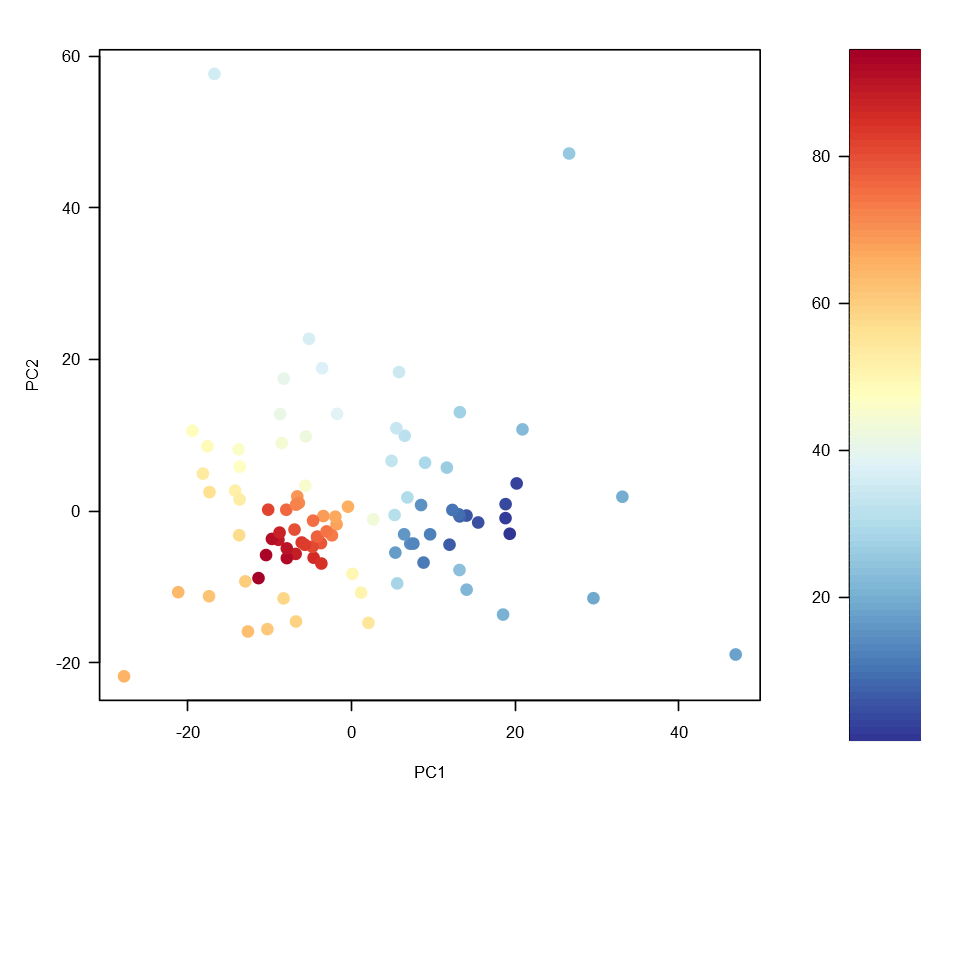

In [38]:
PlotMBorderPCA(sc)

#### 2.2.4.2 Plotting the  pseudo-time ordering in a tSNE map

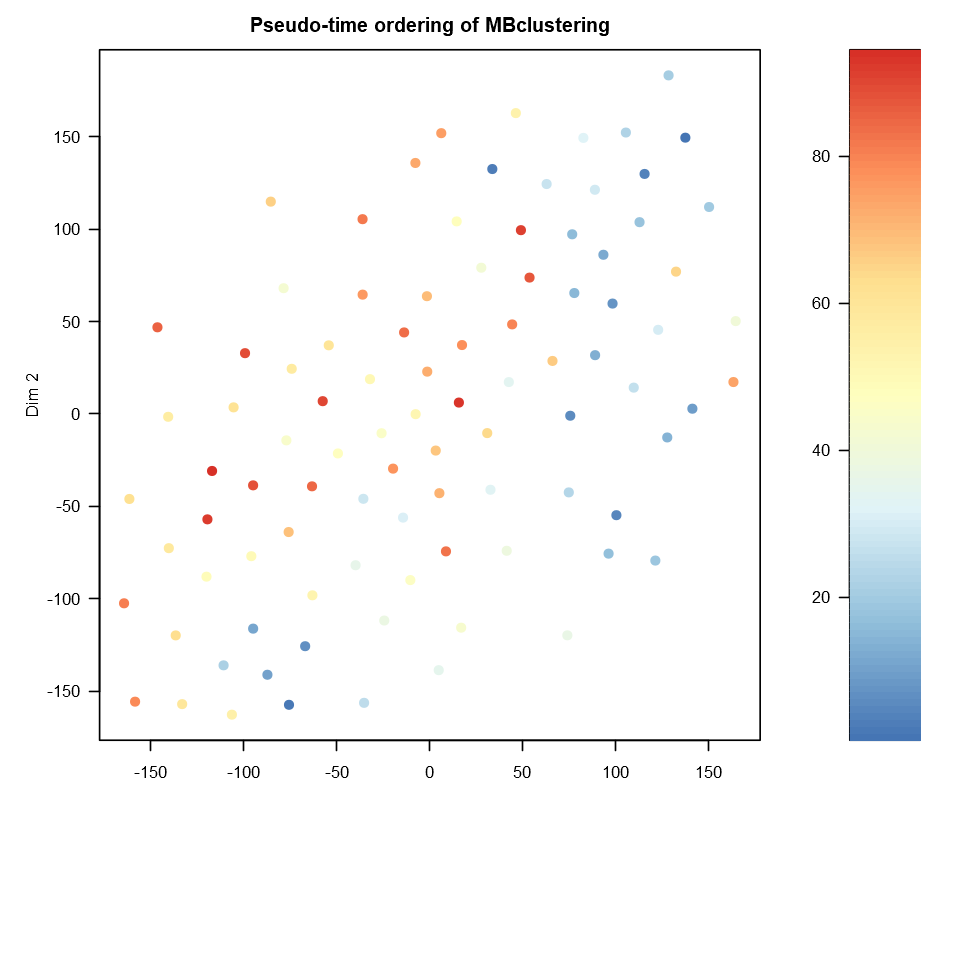

In [39]:
plotOrderMBtsne(sc)

#### 2.2.4.3 Plotting the Model-based clusters in heatmap

Clustering k = 1,2,..., K.max (= 20): .. done
Bootstrapping, b = 1,2,..., B (= 50)  [one "." per sample]:
.................................................. 50 


[1] 2 1 3

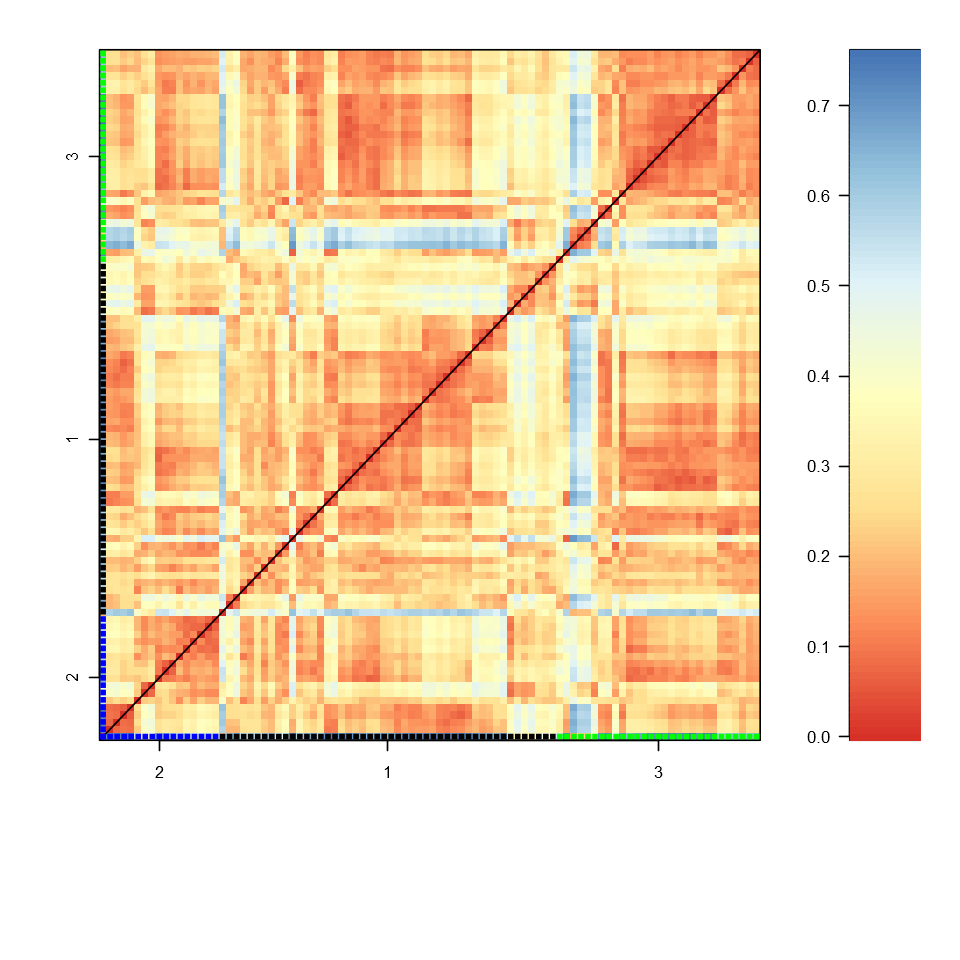

In [40]:
MBclustheatmap(sc,hmethod="single", plot = TRUE) 

#### 2.2.4.4 Plotting the gene expression of a particular gene in a tSNE map

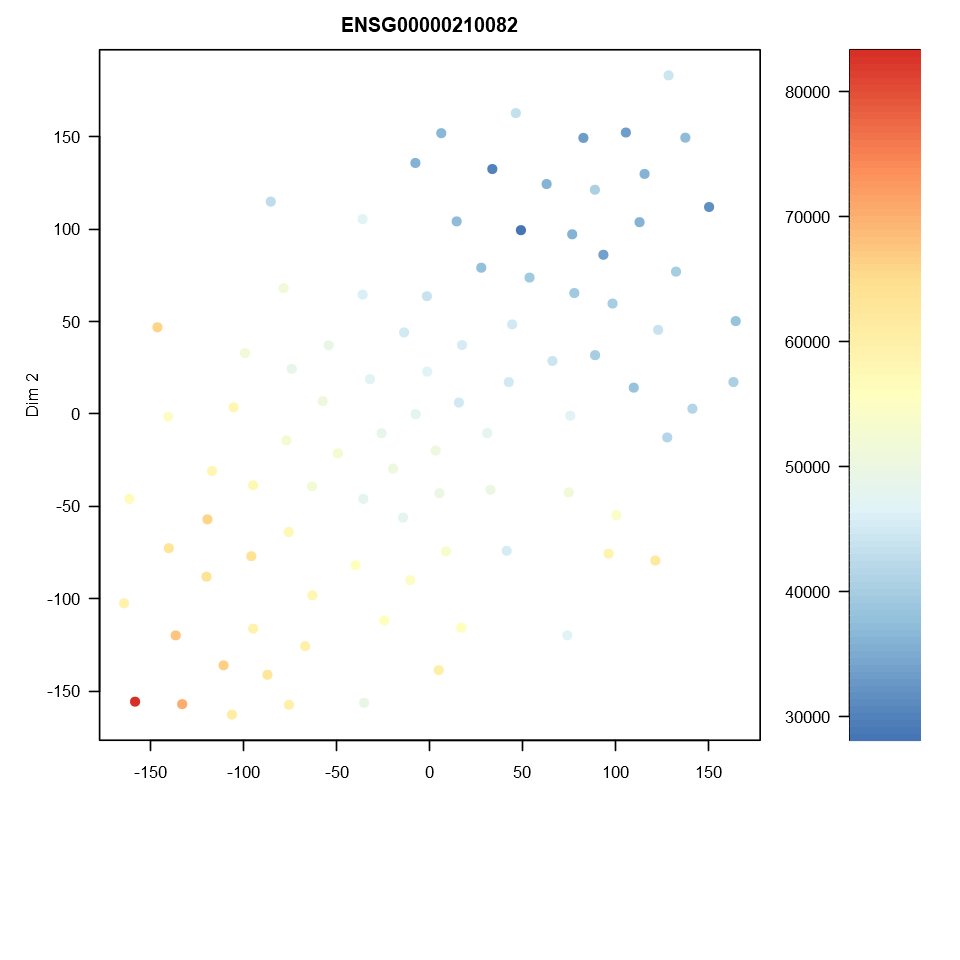

In [41]:
g='ENSG00000210082'                #### Plotting the expression of  MT-RNR2
plotexptsneMB(sc,g)

#### 2.2.4.5 Plotting the gene expression of a particular gene in a PCA plot

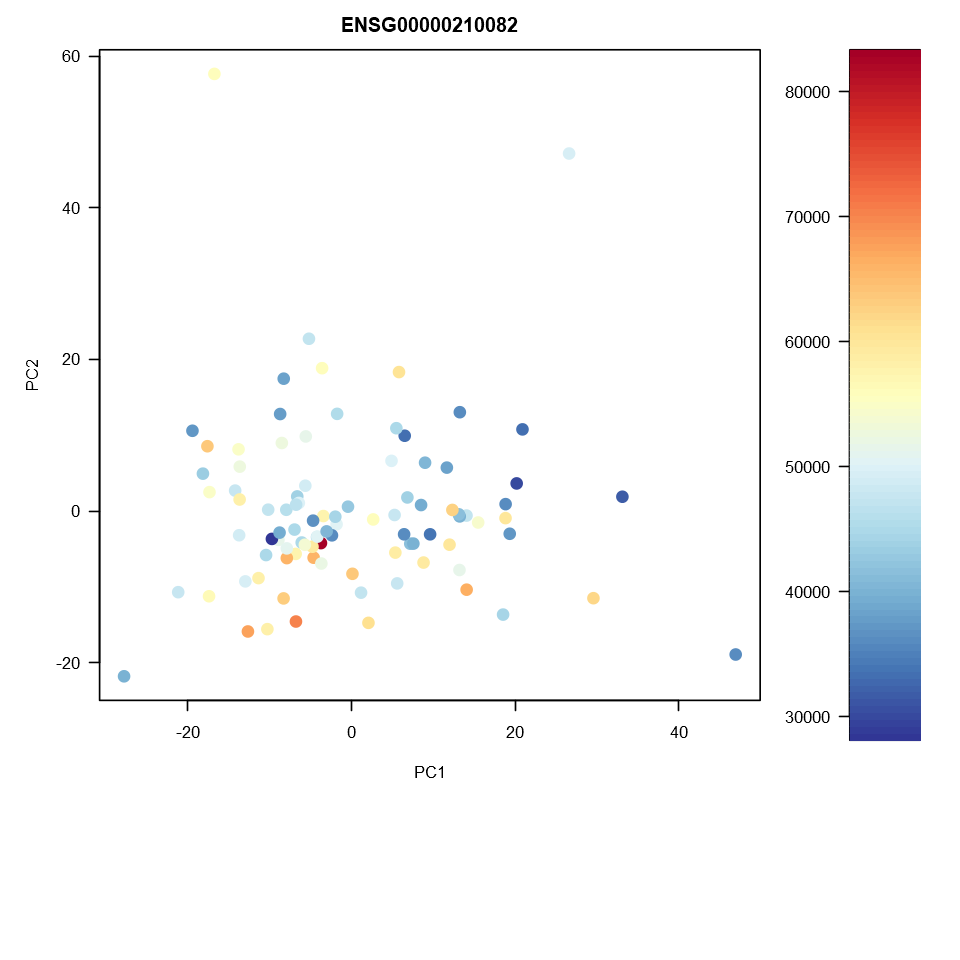

In [42]:
g <- "ENSG00000210082"       #### Plotting the expression of  MT-RNR2
PlotMBexpPCA(sc,g)

## 3. Determining differentially expressed genes (DEGs)

Differentially expressed genes between individual clusters are identified using the significance analysis of sequencing data (SAMseq), which is a new function in significance analysis of microarrays (Li and Tibshirani 2011) in the samr package v2.0 (Tibshirani et all., 2015). SAMseq is a non-parametric statistical function dependent on Wilcoxon rank statistic that equalizes the sizes of the library by a resampling method accounting for the various sequencing depths. The analysis is implemented over the pure raw dataset that has the unnormalized expression read counts after excluding the ERCCs. Furthermore, DEGs in each cluster comparing to all the remaining clusters are determined using binomial differential expression, which is based on binomial counting statistics.

![DIsccBIO](MB2.png)

## 3.1 Identifying DEGs using SAMseq

The user can define DEGs between all clusters generated by either K-means or model based clustering by applying the “DEGanalysis” function. Another alternative is to define DEGs between particular clusters generated by either K-means or model based clustering by applying the “DEGanalysis2clust” function. The outcome of these two functions is a list of two components:
- The first component is a data frame showing the Ensembl gage name and the symbole of the detected DEGs
- The second component is table showing the comparisons, Target cluster, Number of genes and the File name. This component will be used for the downstream analysis.

### 3.1.1 Determining DEGs between two particular clusters

The results of DEGs are saved in your directory 
Low-regulated genes in the CL3 in CL2 VS CL3
The results of DEGs are saved in your directory 
Up-regulated genes in the CL3 in CL2 VS CL3


DEGsE           DEGsS 
[1,] ENSG00000010292 NCAPD2
[2,] ENSG00000011426 ANLN  
[3,] ENSG00000024526 DEPDC1
[4,] ENSG00000072571 HMMR  
[5,] ENSG00000076382 SPAG5 
[6,] ENSG00000079616 KIF22

Comparisons Target cluster Gene number File name                          
1 CL2 VS CL3  CL3            26          Up-regulated-NameCL3inCL2VSCL3.csv 
2 CL2 VS CL3  CL2            26          Low-regulated-NameCL2inCL2VSCL3.csv
  Gene number File name                          
1 146         Low-regulated-NameCL3inCL2VSCL3.csv
2 146         Up-regulated-NameCL2inCL2VSCL3.csv

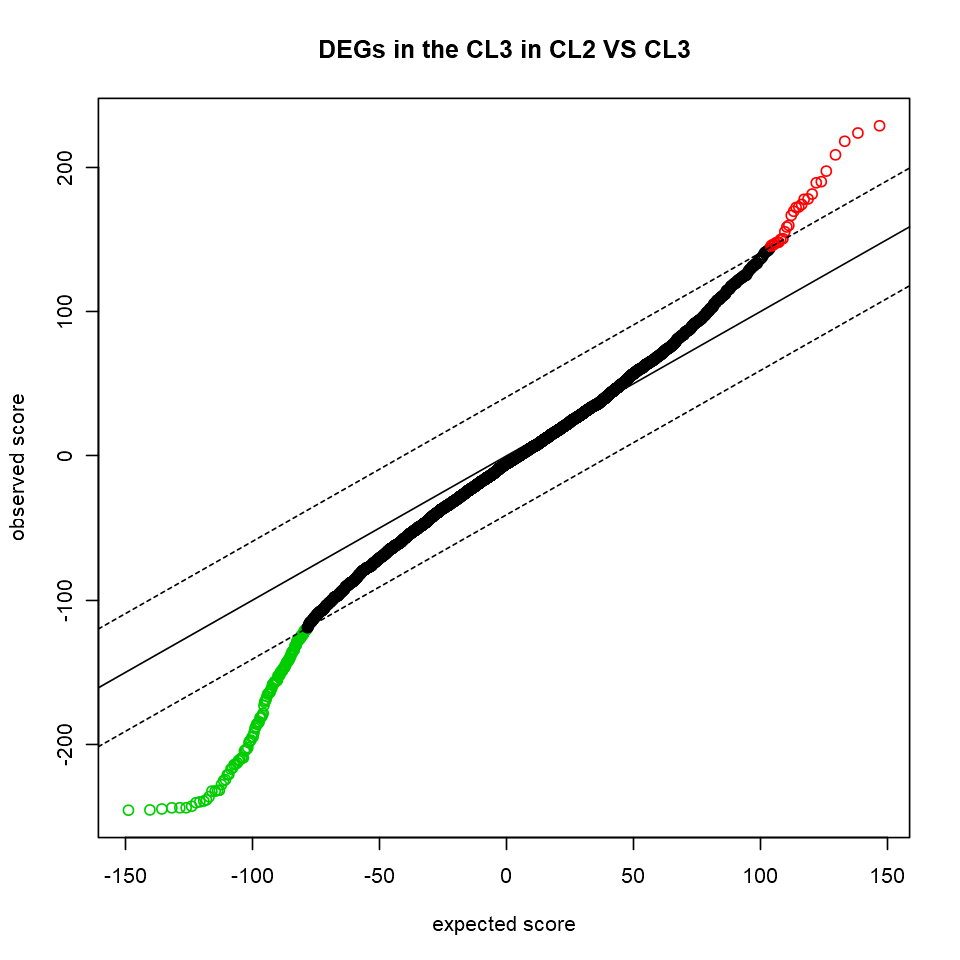

In [43]:
####### differential expression analysis between cluster 2 and cluster 3 of the Model-Based clustering using FDR of 0.05
MBcdiff<-DEGanalysis2clust(sc,Clustering="MB",K=3,fdr=0.05,name="Name",First="CL2",Second="CL3",export = TRUE,quiet=TRUE)   
#### To show the result table
head(MBcdiff[[1]])                  # The first component 
head(MBcdiff[[2]])                  # The second component 

### 3.1.2 Determining DEGs between all clusters

##                                         ¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤ Running this cell will overwrite the previous one ¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤

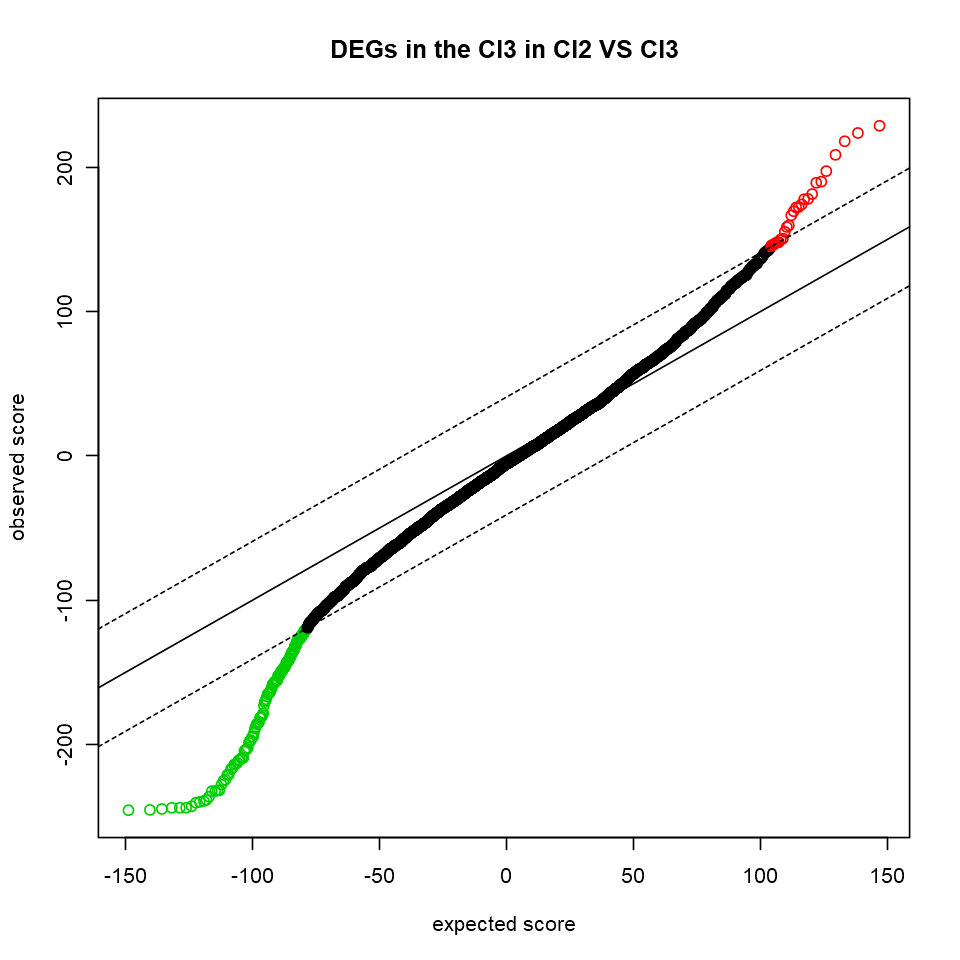

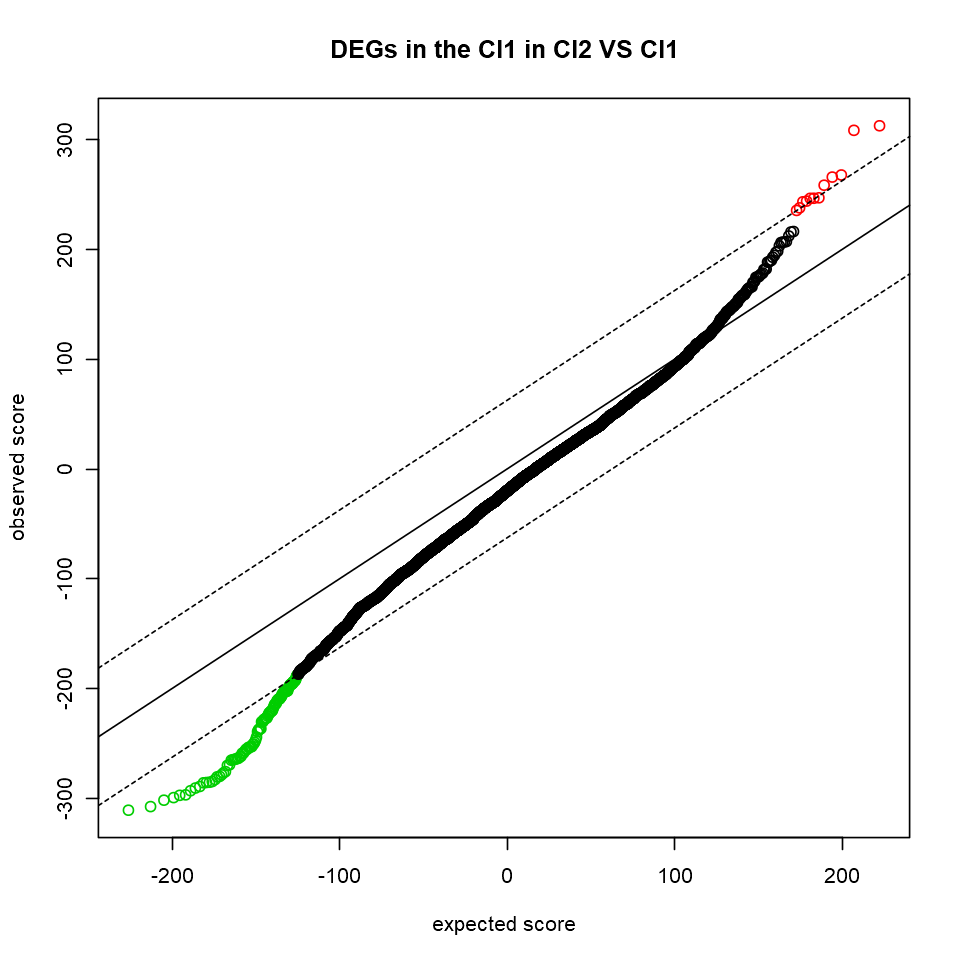

DEGsE           DEGsS 
[1,] ENSG00000010292 NCAPD2
[2,] ENSG00000011426 ANLN  
[3,] ENSG00000024526 DEPDC1
[4,] ENSG00000072571 HMMR  
[5,] ENSG00000076382 SPAG5 
[6,] ENSG00000079616 KIF22

Comparisons Target cluster Gene number
1 Cl2 VS Cl3  Cl3            26         
2 Cl2 VS Cl1  Cl1            12         
3 Cl3 VS Cl1  Cl1             0         
4 Cl2 VS Cl3  Cl2            26         
5 Cl2 VS Cl1  Cl2            12         
6 Cl3 VS Cl1  Cl3             0         
  File name                                   Gene number
1 Up-regulated-all_clustersCl3inCl2VSCl3.csv  146        
2 Up-regulated-all_clustersCl1inCl2VSCl1.csv  115        
3 Up-regulated-all_clustersCl1inCl3VSCl1.csv   10        
4 Low-regulated-all_clustersCl2inCl2VSCl3.csv 146        
5 Low-regulated-all_clustersCl2inCl2VSCl1.csv 115        
6 Low-regulated-all_clustersCl3inCl3VSCl1.csv  10        
  File name                                  
1 Low-regulated-all_clustersCl3inCl2VSCl3.csv
2 Low-regulated-all_clustersCl1inCl2VSCl1.csv
3 Low-regulated-all_clustersCl1inCl3VSCl1.csv
4 Up-regulated-all_clustersCl2inCl2VSCl3.csv 
5 Up-regulated-all_clustersCl2inCl2VSCl1.csv 
6 Up-regulated-all_clustersCl3inCl3VSCl1.csv

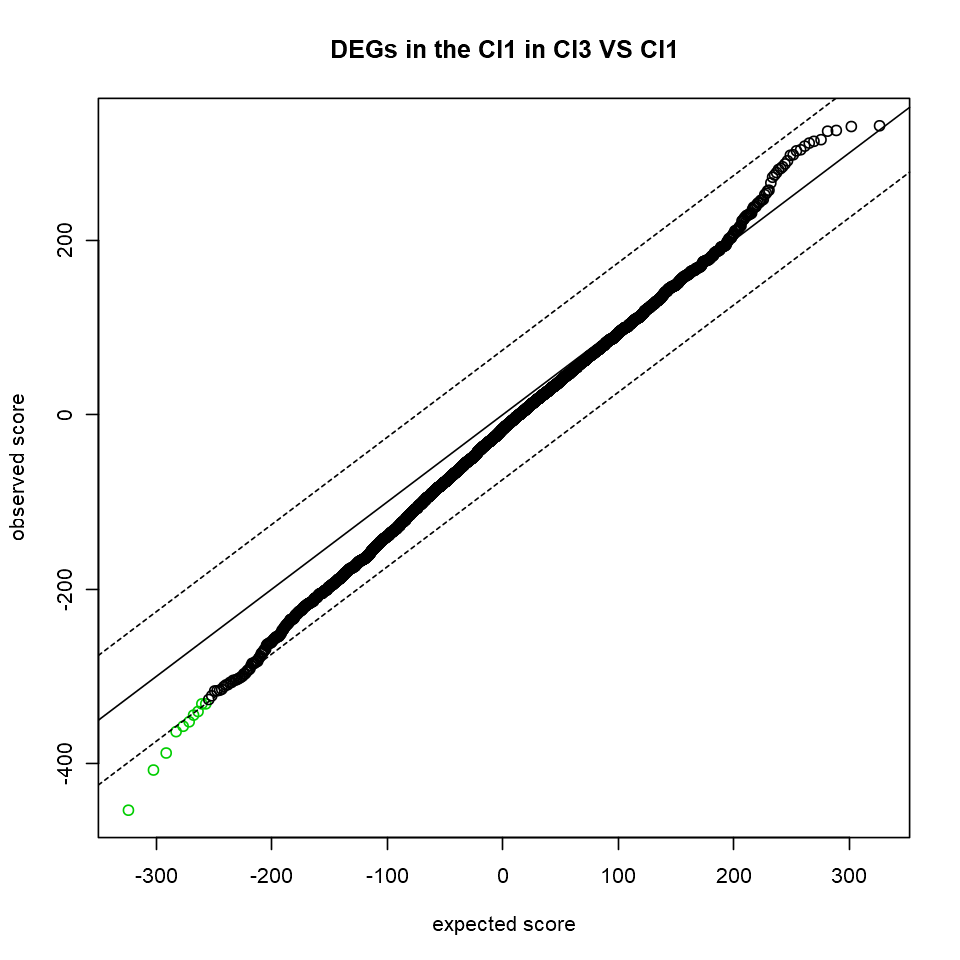

In [44]:
MBcdiff<-DEGanalysis(sc,Clustering="MB",K=3,fdr=0.05,name="all_clusters",export = TRUE,quiet=TRUE)   ####### differential expression analysis between all clusters
#### To show the result table
head(MBcdiff[[1]])                  # The first component 
head(MBcdiff[[2]])                  # The second component

In [45]:
#### To show the result table
head(MBcdiff[[1]])                  # The first component 
head(MBcdiff[[2]])                  # The second component

DEGsE           DEGsS 
[1,] ENSG00000010292 NCAPD2
[2,] ENSG00000011426 ANLN  
[3,] ENSG00000024526 DEPDC1
[4,] ENSG00000072571 HMMR  
[5,] ENSG00000076382 SPAG5 
[6,] ENSG00000079616 KIF22

Comparisons Target cluster Gene number
1 Cl2 VS Cl3  Cl3            26         
2 Cl2 VS Cl1  Cl1            12         
3 Cl3 VS Cl1  Cl1             0         
4 Cl2 VS Cl3  Cl2            26         
5 Cl2 VS Cl1  Cl2            12         
6 Cl3 VS Cl1  Cl3             0         
  File name                                   Gene number
1 Up-regulated-all_clustersCl3inCl2VSCl3.csv  146        
2 Up-regulated-all_clustersCl1inCl2VSCl1.csv  115        
3 Up-regulated-all_clustersCl1inCl3VSCl1.csv   10        
4 Low-regulated-all_clustersCl2inCl2VSCl3.csv 146        
5 Low-regulated-all_clustersCl2inCl2VSCl1.csv 115        
6 Low-regulated-all_clustersCl3inCl3VSCl1.csv  10        
  File name                                  
1 Low-regulated-all_clustersCl3inCl2VSCl3.csv
2 Low-regulated-all_clustersCl1inCl2VSCl1.csv
3 Low-regulated-all_clustersCl1inCl3VSCl1.csv
4 Up-regulated-all_clustersCl2inCl2VSCl3.csv 
5 Up-regulated-all_clustersCl2inCl2VSCl1.csv 
6 Up-regulated-all_clustersCl3inCl3VSCl1.csv

#### 3.2 Identifying DEGs using binomial differential expression

The function MBClustDiffGenes identifies differentially regulated genes for each cluster of the Model-Based clustering in 
comparison to the ensemble of all cells. It returns a list with a data.frame element for each cluster that contains the mean expression across all cells not in the cluster (mean.ncl) and in the cluster (mean.cl), the fold-change in the cluster versus all remaining cells (fc), and the p-value for differential expression between all cells in a cluster and all remaining cells. The p-value is computed based on the overlap of negative binomials fitted to the count distributions within the two groups akin to DESeq.

In [46]:
MBcdiffBinomial<-MBClustDiffGenes(sc,K=3,fdr=.01,export=TRUE, quiet=T)    ########## Binomial differential expression analysis
#### To show the result table
head(MBcdiffBinomial[[1]])                  # The first component 
head(MBcdiffBinomial[[2]])                  # The second component

DEGsE           DEGsS 
[1,] ENSG00000075624 ACTB  
[2,] ENSG00000094804 CDC6  
[3,] ENSG00000101447 FAM83D
[4,] ENSG00000103187 COTL1 
[5,] ENSG00000104738 MCM4  
[6,] ENSG00000112118 MCM3

Target Cluster VS                 Gene number File name           Gene number
1 Cluster 1      Remaining Clusters  13         Up-DEG-cluster1.csv  25        
2 Cluster 2      Remaining Clusters 333         Up-DEG-cluster2.csv 313        
3 Cluster 3      Remaining Clusters  65         Up-DEG-cluster3.csv 133        
  File name            
1 Down-DEG-cluster1.csv
2 Down-DEG-cluster2.csv
3 Down-DEG-cluster3.csv

### Plotting the DEGs

Volcano plots are used to readily show the DEGs by plotting significance versus fold-change on the y and x axes, respectively.

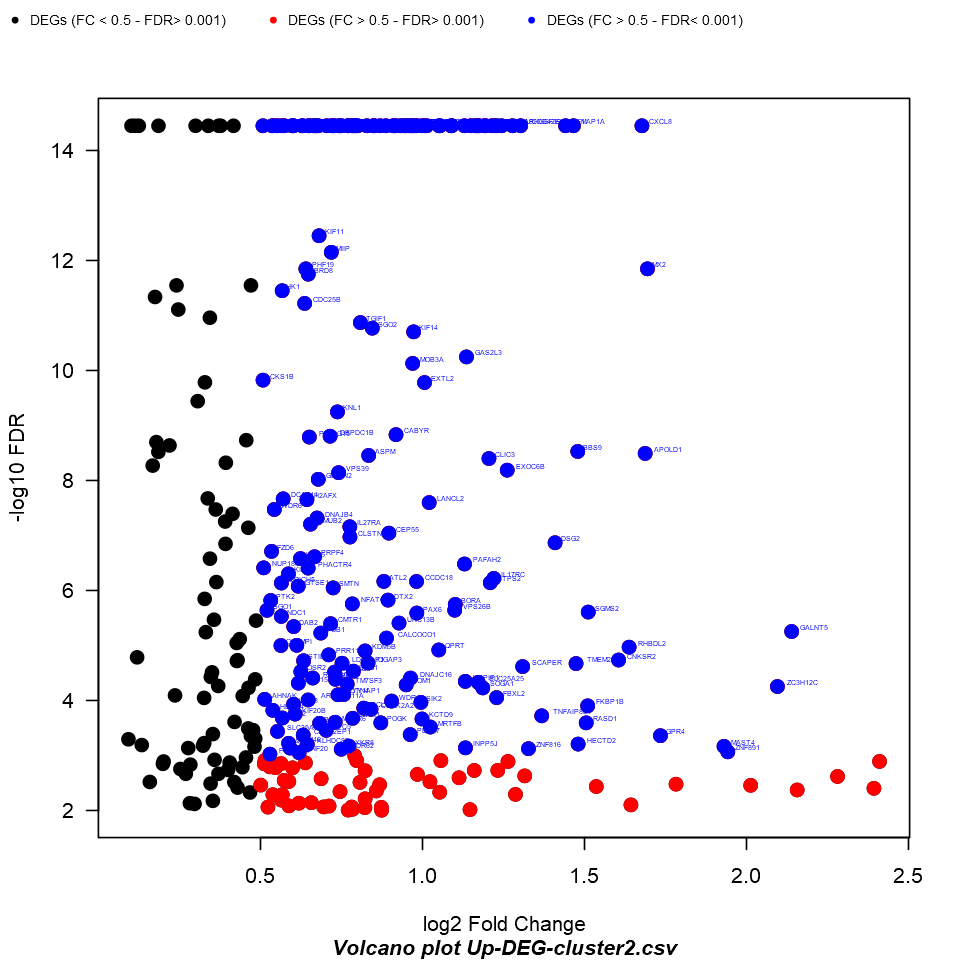

In [47]:
name<-MBcdiffBinomial[[2]][2,4]    ############ Selecting the "Up-DEG-cluster2.csv " from the DEGs' binomial table  ##############
#name<-MBcdiff[[2]][4,6]    ############ Selecting the "Up-DEG-cluster2.csv " from the DEGs' SAMseq table  ##############
U<-read.csv(file=paste0(name),head=TRUE,sep=",")
Vplot<-VolcanoPlot(U,value=0.001,name=name,FS=.3,fc=0.5)
#### In case the output of this function is an error "Error in plot.window(...): need finite 'ylim' values", the adj should be set to TRUE
### In case the user would like to get the names of the significant DEGs then FS should be set to a value of 0.3 or higher.

## 4. Identifying biomarkers (decision trees and networking analysis) 

There are several methods to identify biomarkers, among them are decision trees and hub detection through networking analysis. The outcome of STRING analysis is stored in tab separated values (TSV) files. These TSV files served as an input to check both the connectivity degree and the betweenness centrality, which reflects the communication flow in the defined PPI networks 

![DIsccBIO](MB3.png)

Decision trees are one of the most efficient classification techniques in biomarkers discovery.  Here we use it to predict the sub-population of a target cell based on transcriptomic data. Two types of decision trees can be performed: classification and regression trees (CART) and J48. The decision tree analysis is implemented over a training dataset, which consisted of the DEGs obtained by either SAMseq or the binomial differential expression. The performance of the generated trees can be evaluated for error estimation by ten-fold cross validation assessment using the "J48DTeval" and "RpartEVAL" functions.
The decision tree analysis requires the dataset to be class vectored by applying the “ClassVectoringDT” function.

In [48]:
sigDEG<-cdiff[[1]]             # DEGs gene list from SANseq
#sigDEG<-cdiffBinomial[[1]]      # DEGs gene list from Binomial analysis
First="CL2"
Second="CL3"
DATAforDT<-ClassVectoringDT(sc,Clustering="MB",K=3,First=First,Second=Second,sigDEG)

The DEGs filtered normalized dataset contains:
 Genes: 8 
 cells: 46

### 4.1. J48 Decision Tree

J48 pruned tree
------------------

MTRNR2 <= 41518.323682
|   PXK <= 46.784923
|   |   PPP5C <= 370.82892: CL2 (4.0/1.0)
|   |   PPP5C > 370.82892: CL3 (4.0)
|   PXK > 46.784923: CL2 (7.0)
MTRNR2 > 41518.323682
|   MTRNR2 <= 53816.109212: CL3 (18.0/1.0)
|   MTRNR2 > 53816.109212
|   |   COG8 <= 92.793396
|   |   |   ELP1 <= 176.101741: CL2 (5.0)
|   |   |   ELP1 > 176.101741: CL3 (3.0/1.0)
|   |   COG8 > 92.793396: CL3 (5.0)

Number of Leaves  : 	7

Size of the tree : 	13




=== Summary ===

Correctly Classified Instances          43               93.4783 %
Incorrectly Classified Instances         3                6.5217 %
Kappa statistic                          0.8583
Mean absolute error                      0.1027
Root mean squared error                  0.2266
Relative absolute error                 21.9638 %
Root relative squared error             46.9338 %
Total Number of Instances               46     

=== Confusion Matrix ===

  a  b   <-- classified as
 15  2 |  a = CL2
  1 28 |  b = CL3

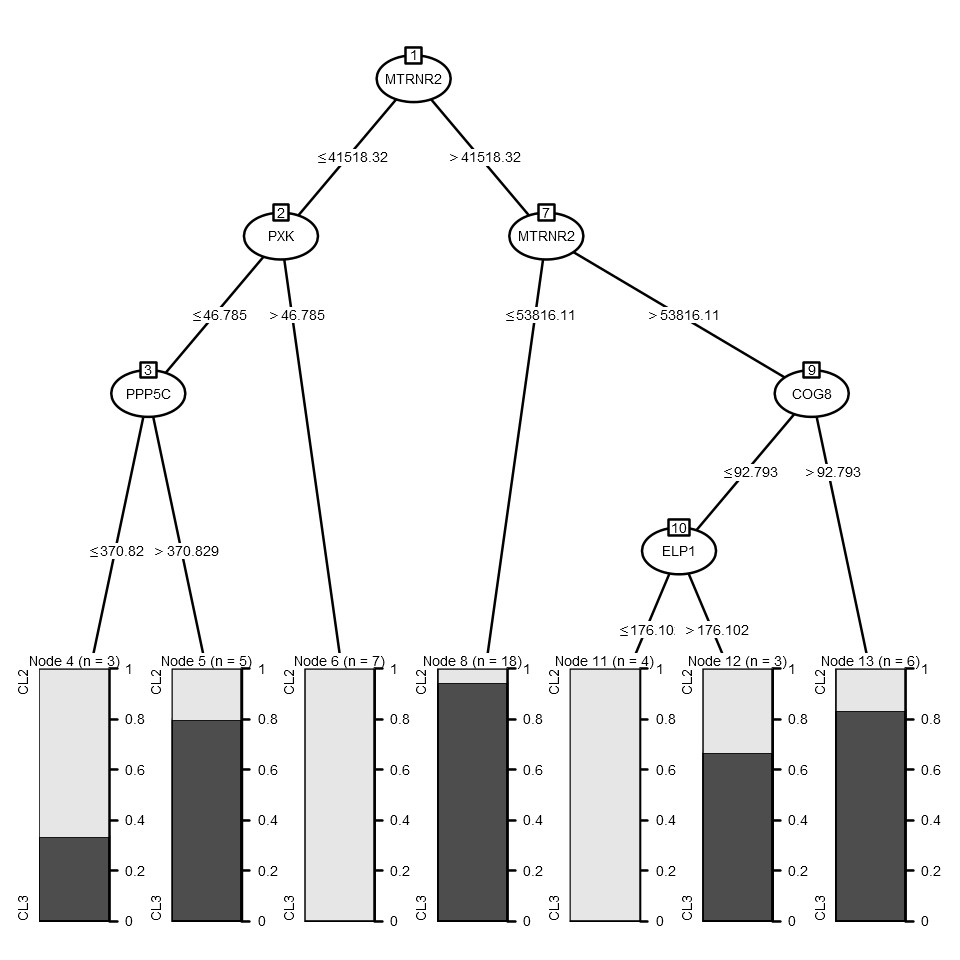

In [49]:
j48dt<-J48DT(DATAforDT)
summary(j48dt) 

#### 4.1.1. Evaluating the performance of the J48 Decision Tree

In [50]:
j48dt<-J48DTeval(DATAforDT,num.folds=10,First=First,Second=Second)

Fold 1 of 10 
Fold 2 of 10 
Fold 3 of 10 
Fold 4 of 10 
Fold 5 of 10 
Fold 6 of 10 
Fold 7 of 10 
Fold 8 of 10 
Fold 9 of 10 
Fold 10 of 10 
TP FN FP TN 
 1 16  4 25 
             CL2 CL3
PredictedCL2   1   4
PredictedCL3  16  25
J48 SN: 0.05882353
J48 SP: 0.862069
J48 ACC: 0.5652174
J48 MCC: -0.1226773


### 4.2. RPART Decision Tree

n= 46 

node), split, n, loss, yval, (yprob)
      * denotes terminal node

 1) root 46 17 CL3 (0.36956522 0.63043478)  
   2) MTRNR2< 41999.57 15  5 CL2 (0.66666667 0.33333333)  
     4) PXK>=48.33224 7  0 CL2 (1.00000000 0.00000000) *
     5) PXK< 48.33224 8  3 CL3 (0.37500000 0.62500000)  
      10) PPP5C< 388.1959 4  1 CL2 (0.75000000 0.25000000)  
        20) ACTB< 55652.35 3  0 CL2 (1.00000000 0.00000000) *
        21) ACTB>=55652.35 1  0 CL3 (0.00000000 1.00000000) *
      11) PPP5C>=388.1959 4  0 CL3 (0.00000000 1.00000000) *
   3) MTRNR2>=41999.57 31  7 CL3 (0.22580645 0.77419355)  
     6) MTRNR2>=58620.64 9  4 CL2 (0.55555556 0.44444444)  
      12) ELP1< 77.58087 4  0 CL2 (1.00000000 0.00000000) *
      13) ELP1>=77.58087 5  1 CL3 (0.20000000 0.80000000)  
        26) ACTB< 37059.54 1  0 CL2 (1.00000000 0.00000000) *
        27) ACTB>=37059.54 4  0 CL3 (0.00000000 1.00000000) *
     7) MTRNR2< 58620.64 22  2 CL3 (0.09090909 0.90909091)  
      14) PXK>=234.4688 1  0 CL2 (1.

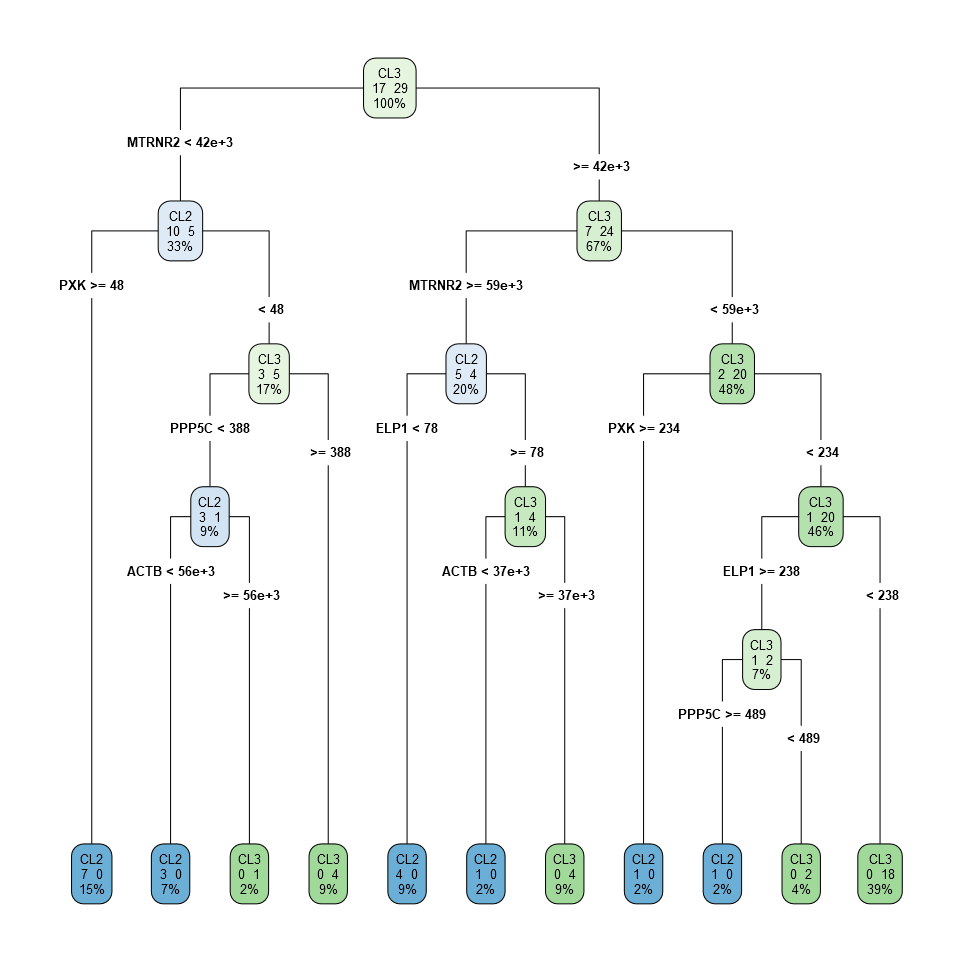

In [51]:
rpartDT<-RpartDT(DATAforDT)

#### 4.2.1. Evaluating the performance of the RPART Decision Tree

In [52]:
rpartEVAL<-RpartEVAL(DATAforDT,num.folds=10,First=First,Second=Second)

Fold 1 of 10 
Fold 2 of 10 
Fold 3 of 10 
Fold 4 of 10 
Fold 5 of 10 
Fold 6 of 10 
Fold 7 of 10 
Fold 8 of 10 
Fold 9 of 10 
Fold 10 of 10 
TP FN FP TN 
 9  8 14 15 
             CL2 CL3
PredictedCL2   9  14
PredictedCL3   8  15
Rpart SN: 0.5294118
Rpart SP: 0.5172414
Rpart ACC: 0.5217391
Rpart MCC: 0.04503773


### 4.3. Networking Analysis

To define protein-protein interactions (PPI) over a list of genes, STRING-api is used. The outcome of STRING analysis was stored in tab separated values (TSV) files. These TSV files served as an input to check both the connectivity degree and the betweenness centrality, which reflects the communication flow in the defined PPI networks.

### 4.3.1 All DEGs

Examine response components = 200 	 200 means successful 


No encoding supplied: defaulting to UTF-8.


Number of nodes:  171 
Number of links:  3931 
Link Density:  22.9883 
The connectance of the graph:  0.1352253 
Mean Distences 1.689381 
Average Path Length 1.689381 
 


names   degree betweenness
89  CDC20   108    200.80162  
107 CDK1    107    240.05487  
40  PLK1    106    162.42845  
13  CCNB1   104     49.31934  
37  MAD2L1  102     91.56594  
30  CCNA2   101    169.77904  
52  AURKB   101    204.28162  
17  NDC80   100     61.01072  
32  BUB1B   100     94.01062  
33  CCNB2   100     41.28941  
45  BUB1    100    155.08390  
4   AURKA    99     13.25971  
16  KIF11    99     66.09399  
87  KIF2C    99    131.11762  
90  CDCA8    97    102.63555  
121 TOP2A    97     52.27875  
25  CENPE    95     38.28040  
75  CENPF    95     57.46790  
29  NUF2     94     56.20195  
44  BIRC5    94     68.31694  
81  TTK      94     84.71821  
41  TPX2     93    105.79144  
69  UBE2C    93    238.75612  
105 PRC1     92     59.65976  
8   DLGAP5   90     28.42951  
39  MELK     90     34.85504  
78  ASPM     89     50.66695  
106 KIF20A   89     40.18122  
15  KIF23    88     14.97653  
103 PTTG1    88     66.48419  
... ...     ...    ...        
149 PLIN3   2      0          
150 SDCBP   2      0          
34  CBR3    1      0          
46  COL3A1  1      0          
68  HN1     1      0          
83  RBMX    1      0          
92  CMTR1   1      0          
93  PHACTR4 1      0          
108 WDR6    1      0          
111 PRMT2   1      0          
113 LAMB2   1      0          
116 MXD3    1      0          
138 TMUB2   1      0          
142 CABYR   1      0          
143 PHF19   1      0          
147 MRPL15  1      0          
154 TIMP3   1      0          
156 MTHFD1  1      0          
157 COTL1   1      0          
161 CMTR2   1      0          
162 KDM5B   1      0          
163 CLPX    1      0          
164 PTTG1IP 1      0          
165 SLC25A3 1      0          
166 FBXO8   1      0          
167 PTK2    1      0          
168 PSAP    1      0          
169 MFSD12  1      0          
170 MOB3A   1      0          
171 PHF7    1      0

Examine response components = 200 	 200 means successful 

 You can see the network with high resolution by clicking on the following link: 
 https://string-db.org/api/highres_image/network?identifiers=NCAPD2%0dANLN%0dDEPDC1%0dHMMR%0dSPAG5%0dKIF22%0dNDC80%0dAURKA%0dTPX2%0dBIRC5%0dRANGAP1%0dCDKN3%0dCDC25B%0dFAM83D%0dPLIN3%0dISYNA1%0dTTK%0dKIF20A%0dSMC4%0dMIIP%0dCDC20%0dNEK2%0dCENPF%0dPHF19%0dKIF18A%0dCKS2%0dDLGAP5%0dTRAF2%0dKNSTRN%0dPIMREG%0dATP8B3%0dTOP2A%0dCCNB1%0dPSRC1%0dCDCA8%0dTROAP%0dCKAP2%0dARHGEF39%0dNUSAP1%0dKIF23%0dKNL1%0dCEP55%0dKIF20B%0dCENPE%0dGAS2L3%0dTOB1%0dKIF2C%0dNUF2%0dCALM2%0dCCNA2%0dMKI67%0dBUB1B%0dCCNB2%0dCBR3%0dCCNF%0dHMGB2%0dPTTG1%0dPLK1%0dTUBA1C%0dREEP4%0dPTK2%0dCKAP2L%0dBUB1%0dCDK1%0dARL6IP1%0dCKS1B%0dRNF26%0dUBE2C%0dCKAP5%0dPNMA1%0dTGIF1%0dAURKB%0dCDCA2%0dIFIT1%0dTUBB4B%0dJPT1%0dHYLS1%0dPRC1%0dMXD3%0dTACC3%0dCABYR%0dSGO2%0dPBK%0dDBF4%0dGTSE1%0dPPP2R5C%0dTOM1%0dKIF14%0dBTG1%0dKIF11%0dPIF1%0dRBMX%0dUGCG%0dPOC1A%0dRAD21%0dCOL3A1%0dTMUB2%0dPTTG1IP%0dPHACTR4%0dASPM%

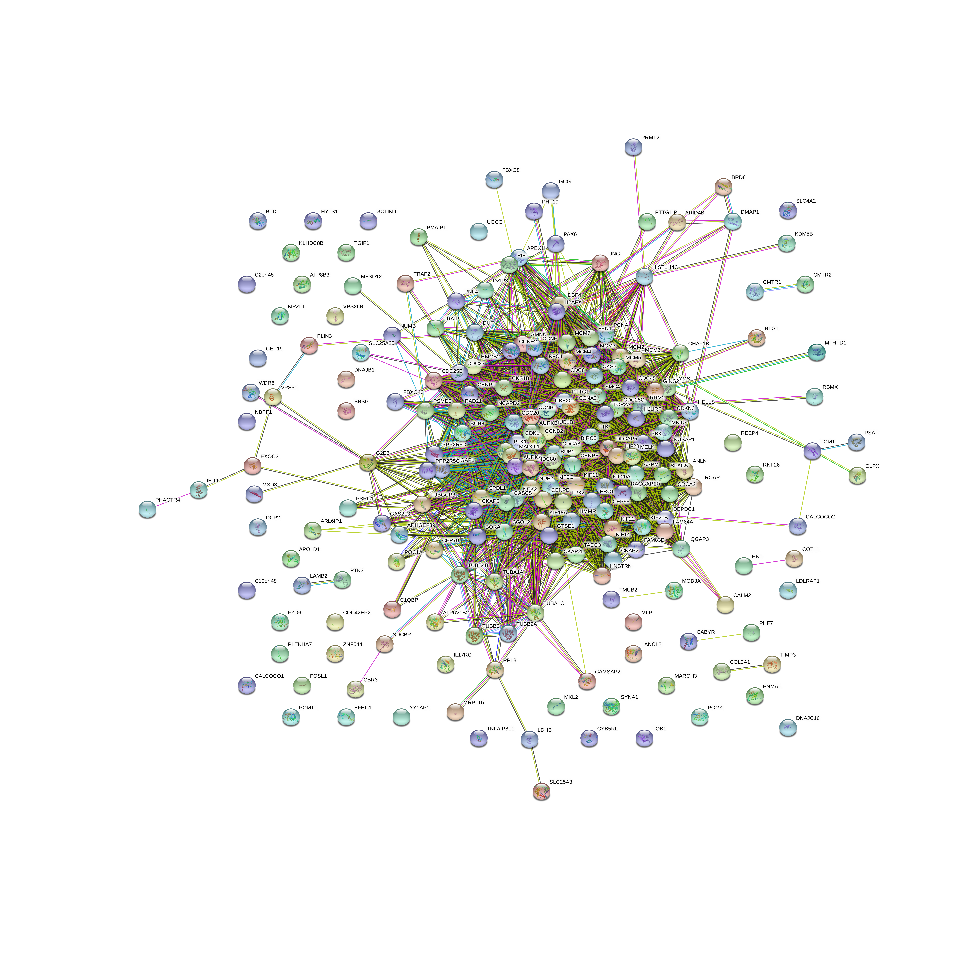

In [53]:
DEGs="All DEGs"
FileName=paste0(DEGs)

#data<-MBcdiffBinomial[[1]] [,2]    # DEGs gene list from Binomial analysis
data<-MBcdiff[[1]] [,2]             # From the table of the differential expression analysis between all pairs of clusters

ppi<-PPI(data,FileName)

networking<-NetAnalysis(ppi)
networking                            ##### In case the Examine response components = 200 and an error "linkmat[i, ]" appeared, that means there are no PPI.

network<-Networking(data,FileName)

### 4.3.2 Particular set of DEGs

Examine response components = 200 	 200 means successful 


No encoding supplied: defaulting to UTF-8.


Number of nodes:  87 
Number of links:  1805 
Link Density:  20.74713 
The connectance of the graph:  0.2412457 
Mean Distences 1.387005 
Average Path Length 1.387005 
 


names    degree betweenness
21  PLK1     69     49.225835  
6   CCNB1    68     16.168104  
51  CDC20    68     55.767606  
62  CDK1     67     58.670028  
17  CCNB2    66     19.232805  
28  AURKB    65     30.037603  
37  UBE2C    65     77.460367  
50  KIF2C    65     40.693785  
52  CDCA8    65     52.382926  
1   AURKA    64      2.949365  
9   KIF11    64     13.941676  
16  BUB1B    64     22.773281  
19  MAD2L1   64     21.620141  
25  BUB1     64     22.770363  
10  NDC80    63     17.109227  
12  CENPE    63      8.104818  
15  CCNA2    63     13.821273  
24  BIRC5    63     30.527222  
40  CENPF    63     23.853202  
60  PRC1     63     32.092674  
14  NUF2     62     12.474772  
22  TPX2     62     35.478865  
46  TTK      62     40.003044  
69  TOP2A    62     17.505360  
3   DLGAP5   60      1.274445  
59  HMMR     60     16.308939  
61  KIF20A   60     16.477782  
20  MELK     59     11.007927  
8   KIF23    58      3.441654  
41  NEK2     58     36.317410  
... ...      ...    ...        
45  BUB3     36     47.6641571 
18  HMGB2    30      0.0000000 
76  CDC27    30      0.0000000 
23  TUBA1C   26     22.5750000 
2   CDC25B   25      0.0000000 
75  H2AFX    23      0.0000000 
64  RANGAP1  20      0.1111111 
72  PPP2R5D  20      0.0000000 
36  TUBB4B   18     23.0190476 
58  TUBB2A   13      0.6250000 
77  GAS2L3   11      0.0000000 
57  ARHGEF39 10      5.6825397 
11  CEP70     9      0.0000000 
66  FBXO43    9      0.0000000 
29  TUBB6     8      0.0000000 
32  PIF1      8      0.0000000 
33  TRAIP     7      0.0312500 
47  PSRC1     6      0.0000000 
67  PAX6      6      0.1726190 
82  CALM2     4      0.0000000 
81  ATP6V1B2  3      0.0000000 
49  IFIT1     2      1.0000000 
53  SLC25A25  2      0.0000000 
84  ARL6IP1   2      0.0000000 
54  PHACTR4   1      0.0000000 
65  MXD3      1      0.0000000 
83  EXOC2     1      0.0000000 
85  FBXO8     1      0.0000000 
86  BRD8      1      0.0000000 
87  MFSD12    1      0.0000000

Examine response components = 200 	 200 means successful 

 You can see the network with high resolution by clicking on the following link: 
 https://string-db.org/api/highres_image/network?identifiers=PAX6%0dANLN%0dDEPDC1%0dKIF22%0dNDC80%0dAURKA%0dBIRC5%0dFAM83D%0dTTK%0dBRD8%0dKIF20A%0dCDC20%0dNEK2%0dCENPF%0dHJURP%0dCKS2%0dDLGAP5%0dKNSTRN%0dPIMREG%0dTOP2A%0dPSRC1%0dCDCA8%0dTROAP%0dCKAP2%0dARHGEF39%0dTUBB2A%0dNUSAP1%0dKIF23%0dGAS2L3%0dPIF1%0dKIF2C%0dNUF2%0dCCNA2%0dCDC42EP2%0dBUB3%0dBUB1B%0dCBR3%0dCCNF%0dMELK%0dPLEKHA7%0dPLK1%0dTUBA1C%0dPBK%0dCKAP2L%0dCDK1%0dARL6IP1%0dCKS1B%0dRNF26%0dUBE2C%0dCKAP5%0dAPOLD1%0dAURKB%0dCDCA2%0dTUBB4B%0dHYLS1%0dMXD3%0dMOB3A%0dCALCOCO1%0dHMMR%0dSPAG5%0dPLIN3%0dPPP2R5D%0dSMC4%0dKDM5B%0dMKI67%0dPRMT2%0dHMGB2%0dMAD2L1%0dBUB1%0dTGIF1%0dCDC27%0dTPX2%0dRANGAP1%0dCCNB1%0dCALCOCO2%0dFBXO43%0dMFSD12%0dYY1AP1%0dKIF15%0dDCP2%0dTUBB6%0dH2AFX%0dMIIP%0dLANCL2%0dKIF11%0dCCNB2%0dLDLRAP1%0dFBXO8%0dTRAIP%0dIQGAP3%0dPHACTR4%0dCYB5RL%0dCDKN3%0dCEP70%0dREEP4%0dCDC25B%0dCALM2%0dV

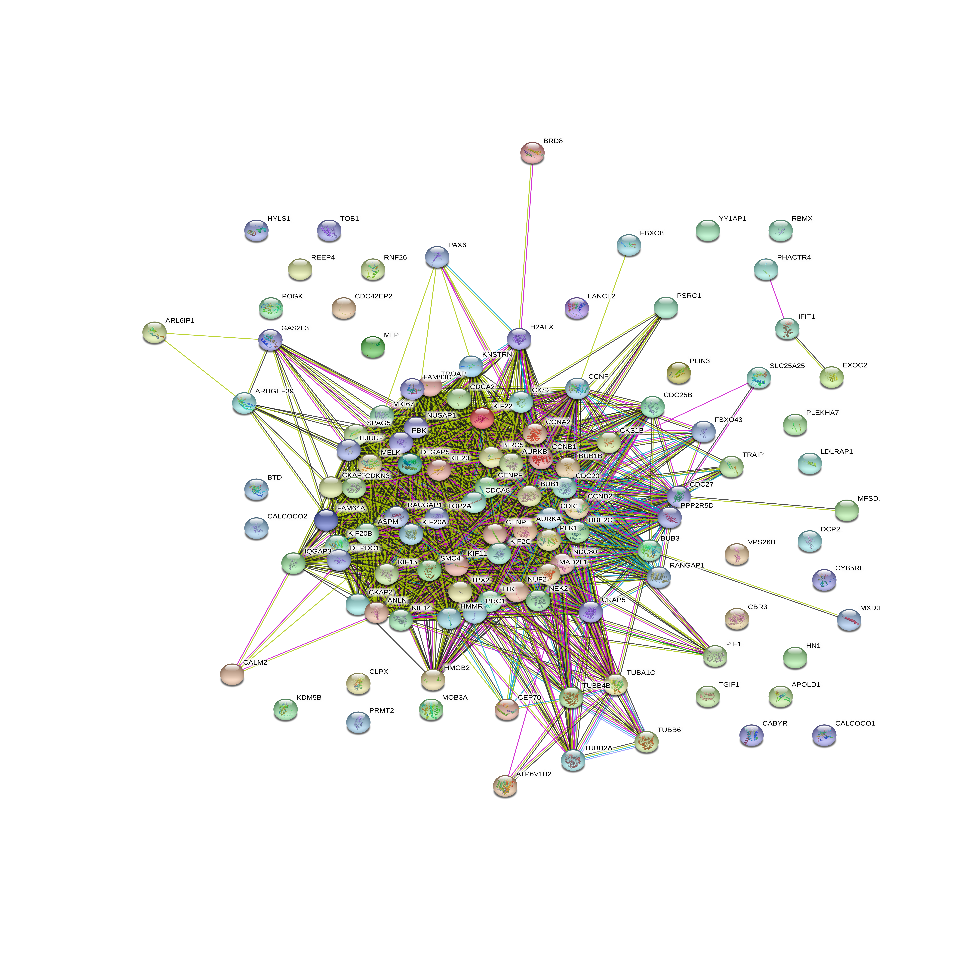

In [54]:
############ Selecting the DEGs' table  ##############
#DEGs=cdiffBinomial[[2]][2,4]     # UP-regulated genes in cluster 2 (from the Binomial analysis)
DEGs=MBcdiff[[2]][2,6]             # UP-regulated genes in cluster 2 (from SAMseq)
FileName=paste0(DEGs)

data<-read.csv(file=paste0(DEGs),head=TRUE,sep=",")
data<-data[,3]

ppi<-PPI(data,FileName)

networking<-NetAnalysis(ppi)
networking                            ##### In case the Examine response components = 200 and an error "linkmat[i, ]" appeared, that means there are no PPI.

network<-Networking(data,FileName)


### 4.4 Gene Enrichment Analysis

In [55]:
dbs <- listEnrichrDbs()
head(dbs)
#print(dbs)

geneCoverage genesPerTerm libraryName                     
1 13362         275         Genome_Browser_PWMs             
2 27884        1284         TRANSFAC_and_JASPAR_PWMs        
3  6002          77         Transcription_Factor_PPIs       
4 47172        1370         ChEA_2013                       
5 47107         509         Drug_Perturbations_from_GEO_2014
6 21493        3713         ENCODE_TF_ChIP-seq_2014         
  link                                                     numTerms
1 http://hgdownload.cse.ucsc.edu/goldenPath/hg18/database/ 615     
2 http://jaspar.genereg.net/html/DOWNLOAD/                 326     
3                                                          290     
4 http://amp.pharm.mssm.edu/lib/cheadownload.jsp           353     
5 http://www.ncbi.nlm.nih.gov/geo/                         701     
6 http://genome.ucsc.edu/ENCODE/downloads.html             498

In [56]:
############ Selecting the DEGs' table  ##############
#DEGs=MBcdiffBinomial[[2]][2,4]     # Up-regulated genes in cluster 2 (from the Binomial analysis)
DEGs=MBcdiff[[2]][2,6]              # UP-regulated genes in cluster 2 (from SAMseq)
data<-read.csv(file=paste0(DEGs),head=TRUE,sep=",")
data<-as.character(data[,3])

dbs <- c("KEGG_2013","GO_Molecular_Function_2015", "GO_Biological_Process_2015")
enriched <- enrichr(data, dbs)
KEGG_2013<-enriched[[1]][,c(1,2,3,9)]
GO_Molecular_Function_2015<-enriched[[2]][,c(1,2,3,9)]
GO_Biological_Process_2015<-enriched[[3]][,c(1,2,3,9)]

GEA<-rbind(KEGG_2013,GO_Molecular_Function_2015,GO_Biological_Process_2015)
GEA

Uploading data to Enrichr... Done.
  Querying KEGG_2013... Done.
  Querying GO_Molecular_Function_2015... Done.
  Querying GO_Biological_Process_2015... Done.
Parsing results... Done.


Term                                                                                  
1    HSA04110 CELL CYCLE                                                                   
2    HSA04120 UBIQUITIN MEDIATED PROTEOLYSIS                                               
3    HSA05130 PATHOGENIC ESCHERICHIA COLI INFECTION EHEC                                   
4    HSA05131 PATHOGENIC ESCHERICHIA COLI INFECTION EPEC                                   
5    HSA04540 GAP JUNCTION                                                                 
6    HSA00780 BIOTIN METABOLISM                                                            
7    HSA04115 P53 SIGNALING PATHWAY                                                        
8    HSA00440 AMINOPHOSPHONATE METABOLISM                                                  
9    HSA00626 NAPHTHALENE AND ANTHRACENE DEGRADATION                                       
10   HSA04950 MATURITY ONSET DIABETES OF THE YOUNG                                         
11   HSA00450 SELENOAMINO ACID METABOLISM                                                  
12   HSA04740 OLFACTORY TRANSDUCTION                                                       
13   HSA05040 HUNTINGTONS DISEASE                                                          
14   HSA00340 HISTIDINE METABOLISM                                                         
15   HSA00590 ARACHIDONIC ACID METABOLISM                                                  
16   HSA00150 ANDROGEN AND ESTROGEN METABOLISM                                             
17   HSA00350 TYROSINE METABOLISM                                                          
18   HSA00380 TRYPTOPHAN METABOLISM                                                        
19   HSA05214 GLIOMA                                                                       
20   HSA05120 EPITHELIAL CELL SIGNALING IN HELICOBACTER PYLORI INFECTION                   
21   HSA04720 LONG TERM POTENTIATION                                                       
22   HSA04070 PHOSPHATIDYLINOSITOL SIGNALING SYSTEM                                        
23   HSA05210 COLORECTAL CANCER                                                            
24   HSA05222 SMALL CELL LUNG CANCER                                                       
25   HSA04512 ECM RECEPTOR INTERACTION                                                     
26   HSA04912 GNRH SIGNALING PATHWAY                                                       
27   HSA04916 MELANOGENESIS                                                                
28   HSA00190 OXIDATIVE PHOSPHORYLATION                                                    
29   HSA04910 INSULIN SIGNALING PATHWAY                                                    
30   HSA04020 CALCIUM SIGNALING PATHWAY                                                    
...  ...                                                                                   
1328 defense response to other organism (GO:0098542)                                       
1329 regulation of cell adhesion (GO:0030155)                                              
1330 regulation of sequence-specific DNA binding transcription factor activity (GO:0051090)
1331 alcohol metabolic process (GO:0006066)                                                
1332 cytokine-mediated signaling pathway (GO:0019221)                                      
1333 Fc receptor signaling pathway (GO:0038093)                                            
1334 regulation of endopeptidase activity (GO:0052548)                                     
1335 tissue morphogenesis (GO:0048729)                                                     
1336 cellular metal ion homeostasis (GO:0006875)                                           
1337 negative regulation of transport (GO:0051051)                                         
1338 protein oligomerization (GO:0051259)                                                  
1339 monovalent inorganic cation transport (GO:00